# SoCal EVCS Network analysis

**Author: [Jarvis Yuan](www.linkedin.com/in/jarvis-yuan)**

In [1048]:
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
from scipy import stats
import haversine as hs
from shapely import geometry
import pyproj
import mapclassify
import geoplot.crs as gcrs
import geoplot
import collections
from haversine import haversine, Unit

from esda.moran import Moran
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, AgglomerativeClustering

import contextily as cx
import warnings
import mapclassify as mc
import cenpy as cp

warnings.filterwarnings('ignore')

In [5]:
os.chdir('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork')
os.getcwd()

'/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork'

# Extract Roadway Network with osmnx

## Extract from custom bonding box on entire SoCal region

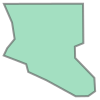

In [428]:
bbox = [[-117.780360058,33.3834315757], [-118.2254136354,33.6270330842],
        [-118.4992028028,33.7524390501], [-118.5306597501,33.8702505871],
        [-118.8714719564,34.0016338706], [-118.8188845665,34.1118843391],
        [-118.7057865411,34.2508358116], [-118.7449038774,34.5004071652],
        [-118.8681996614,34.7840823241], [-117.669498995,34.7864790651],
        [-117.6645851881,34.1891744165], [-117.7930683643,34.1363620016],
        [-117.7893132717,33.9653145708], [-117.4975264818,33.6624559519],
        [-117.4861431867,33.4605582062], [-117.5918570906,33.385975796],
        [-117.780360058,33.3834315757]]

bbox_points = []
for p in bbox:
    bbox_points += [geometry.Point(p[0], p[1])]

poly = geometry.Polygon([[p.x, p.y] for p in bbox_points])
poly

In [372]:
# only project the graph after adding EVCS nodes

cf = '["highway"~"motorway|primary"]'
G_og = ox.graph_from_polygon(poly, custom_filter=cf, simplify=False)
G_og = ox.utils_graph.remove_isolated_nodes(G_og)
G_og = ox.simplify_graph(G_og)

## Condolidate and Project Network

In [1107]:
# takes about 20s
# projection for consistency
G = ox.project_graph(G_og, to_crs='EPSG:3857')

# consolidate intersections by merging nearby nodes with tolerance of projected unit, m
G = ox.consolidate_intersections(G, tolerance=150, rebuild_graph=True, dead_ends=False)

In [555]:
# another copy for centrality analysis without adding EVCS nodes later
G2 = ox.project_graph(G_og, to_crs='EPSG:3857')
G2 = ox.consolidate_intersections(G2, tolerance=150, rebuild_graph=True, dead_ends=False)

In [374]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
print("Coordinate system:", edges.crs)

Coordinate system: EPSG:3857


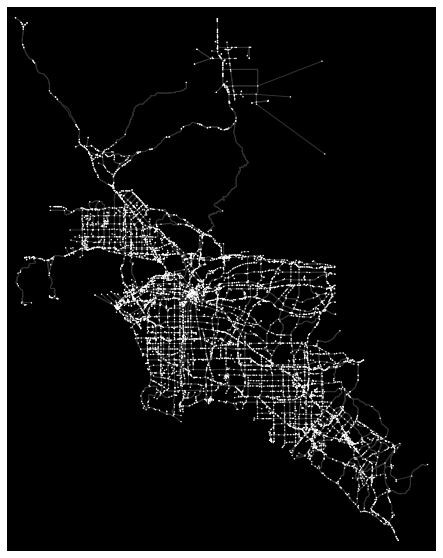

In [560]:
fig, ax = ox.plot_graph(
    G, 
    bgcolor='black', 
    edge_color="#333333", node_color="white", node_size=2, 
    figsize=(10, 10)
)

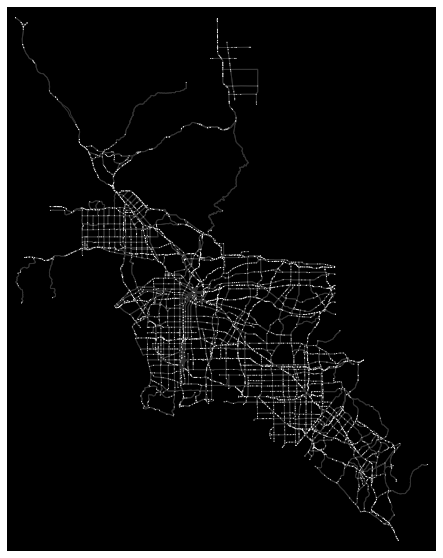

In [558]:
# plotting G2, should have same number of noes as G

fig, ax = ox.plot_graph(
    G2, 
    bgcolor='black', 
    edge_color="#333333", node_color="white", node_size=1, 
    figsize=(10, 10)
)

---

Simple network edge centrality analysis experiment

## Centrality Measures

In [1108]:
# extract a list of edge attributes

list(list(G.edges(data=True))[0][-1].keys())

['osmid',
 'oneway',
 'lanes',
 'name',
 'highway',
 'maxspeed',
 'length',
 'geometry',
 'u_original',
 'v_original']

In [1109]:
# takes 2 min on G, the concolidated graph
# add network centrality measures

extended_stats_G = ox.extended_stats(G, ecc=False, bc=True, cc=True)

nx.set_node_attributes(G, extended_stats_G["betweenness_centrality"], "bc")
nx.set_node_attributes(G, extended_stats_G["closeness_centrality"], "cc")
nx.set_node_attributes(G, extended_stats_G["degree_centrality"], "dc")

In [516]:
# takes about 2 minutes on G, the concolidated graph

edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

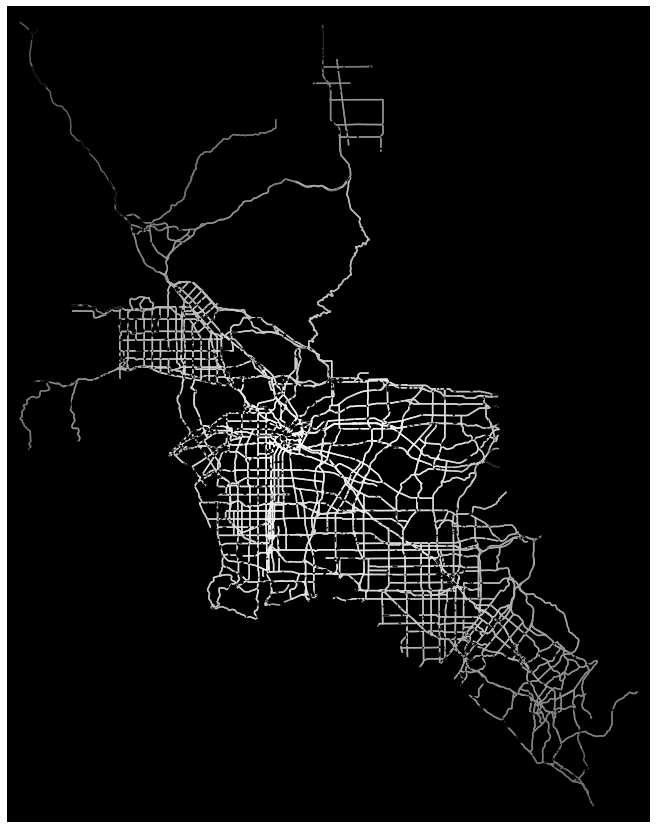

In [524]:
# color edges in original graph with closeness centralities from line graph

ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='Greys_r')
fig, ax = ox.plot_graph(
    G, 
    bgcolor="black", edge_color=ec, node_color="greys-r", 
    node_size=0, 
    figsize=(15, 15),
    edge_linewidth=1.5,
    edge_alpha=0.9
)

## Nodes with highest centrality measures on consolidated street network, G2

In [563]:
extended_stats_G2 = ox.extended_stats(G2, ecc=False, bc=True, cc=True)

In [564]:
extended_stats_G2.keys()

dict_keys(['avg_neighbor_degree', 'avg_neighbor_degree_avg', 'avg_weighted_neighbor_degree', 'avg_weighted_neighbor_degree_avg', 'degree_centrality', 'degree_centrality_avg', 'clustering_coefficient', 'clustering_coefficient_avg', 'clustering_coefficient_weighted', 'clustering_coefficient_weighted_avg', 'pagerank', 'pagerank_max_node', 'pagerank_max', 'pagerank_min_node', 'pagerank_min', 'closeness_centrality', 'closeness_centrality_avg', 'betweenness_centrality', 'betweenness_centrality_avg'])

In [565]:
# values are normalized by default

max_node_bc, max_bc = max(extended_stats_G2["betweenness_centrality"].items(), key=lambda x: x[1])
max_node_cc, max_cc = max(extended_stats_G2["closeness_centrality"].items(), key=lambda x: x[1])
max_node_dc, max_dc = max(extended_stats_G2["degree_centrality"].items(), key=lambda x: x[1])

print('Max Betweennes Centrality: Node', max_node, max_bc)
print('Max Closeness Centrality: Node', max_node_cc, max_cc)
print('Max Degree Centrality: Node', max_node_dc, max_dc)

Max Betweennes Centrality: Node 14689241 0.2546224023000946
Max Closeness Centrality: Node 1529 2.2169590334100638e-05
Max Degree Centrality: Node 2175 0.017892644135188866


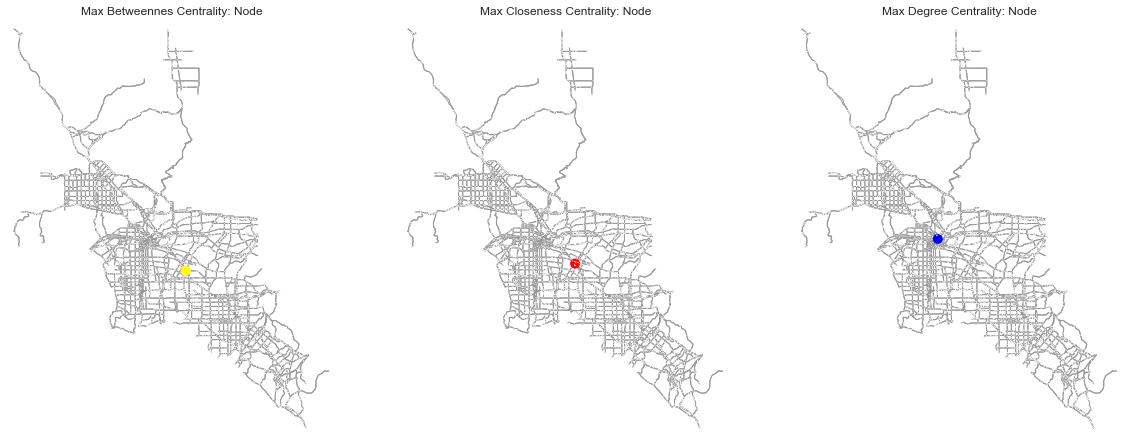

In [633]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

nc_bc = ["yellow" if node == max_node_bc else "w" for node in G2.nodes()] # node color
ns_bc = [100 if node == max_node_bc else 1 for node in G2.nodes()] # node size

nc_cc = ["red" if node == max_node_cc else "w" for node in G2.nodes()]
ns_cc = [100 if node == max_node_cc else 1 for node in G2.nodes()]

nc_dc = ["blue" if node == max_node_dc else "w" for node in G2.nodes()]
ns_dc = [100 if node == max_node_dc else 1 for node in G2.nodes()]

# plotting on consolidated network

ox.plot_graph(G2, node_size=ns_bc, node_color=nc_bc, node_zorder=2, bgcolor="white", show=False, close=False, ax=axs[0]);
axs[0].set_title('Max Betweennes Centrality: Node')
axs[0].set_facecolor('w')

ox.plot_graph(G2, node_size=ns_cc, node_color=nc_cc, node_zorder=2, bgcolor="white", show=False, close=False, ax=axs[1]);
axs[1].set_title('Max Closeness Centrality: Node')
axs[1].set_facecolor('w')

ox.plot_graph(G2, node_size=ns_dc, node_color=nc_dc, node_zorder=2, bgcolor="white", show=False, close=False, ax=axs[2]);
axs[2].set_title('Max Degree Centrality: Node')
axs[2].set_facecolor('w')

plt.show()
# fig.savefig('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork/plot/max_centrality_node.png', dpi=300)

In [628]:
nx.set_node_attributes(G2, extended_stats_G2["betweenness_centrality"], "bc")
nx.set_node_attributes(G2, extended_stats_G2["closeness_centrality"], "cc")
nx.set_node_attributes(G2, extended_stats_G2["degree_centrality"], "dc")

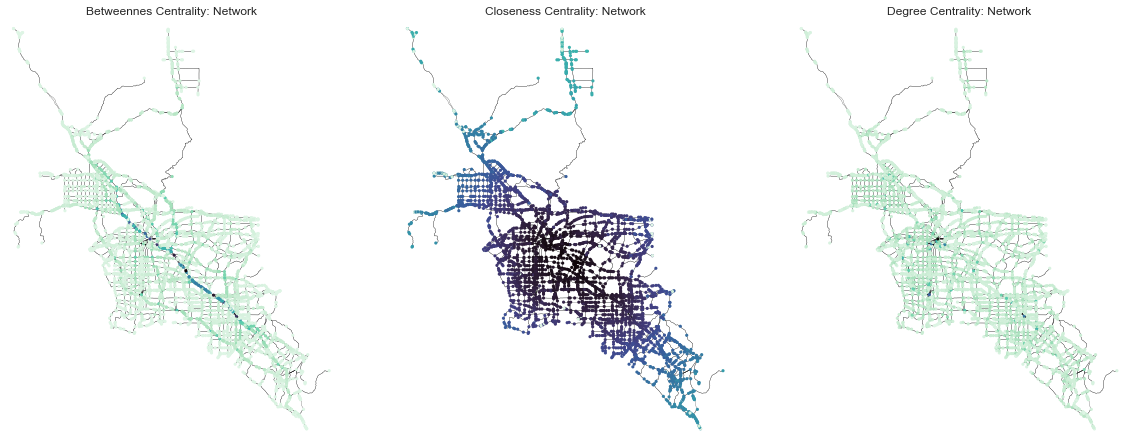

In [632]:
nc_bc = ox.plot.get_node_colors_by_attr(G2, "bc", cmap="mako_r")
nc_cc = ox.plot.get_node_colors_by_attr(G2, "cc", cmap="mako_r")
nc_dc = ox.plot.get_node_colors_by_attr(G2, "dc", cmap="mako_r")


fig, axs = plt.subplots(1, 3, figsize=(20, 10))

ox.plot_graph(
    G2,
    node_color=nc_bc,
    figsize=(10, 10),
    node_size=10,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="k", show=False, close=False,
    bgcolor="w", ax=axs[0]
);
axs[0].set_title('Betweennes Centrality: Network')
axs[0].set_facecolor('w')

ox.plot_graph(
    G2,
    node_color=nc_cc,
    figsize=(10, 10),
    node_size=10,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="k", show=False, close=False,
    bgcolor="w", ax=axs[1]
);
axs[1].set_title('Closeness Centrality: Network')
axs[1].set_facecolor('w')

ox.plot_graph(
    G2,
    node_color=nc_dc,
    figsize=(10, 10),
    node_size=10,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="k", show=False, close=False,
    bgcolor="w", ax=axs[2]
);
axs[2].set_title('Degree Centrality: Network')
axs[2].set_facecolor('w')

fig.savefig('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork/plot/centrality_network.png', dpi=300)

In [1526]:
nodes_proj = ox.graph_to_gdfs(G2, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print('network area = ', graph_area_m, 'm^2')
ox.basic_stats(G2, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')
# reduced the network complexity by a factor of ~10 after consolidation

network area =  16763063550.997362 m^2


{'n': 4025,
 'm': 8871,
 'k_avg': 4.4079503105590065,
 'intersection_count': 2152,
 'streets_per_node_avg': 1.6342857142857143,
 'streets_per_node_counts': {0: 0, 1: 0, 2: 29, 3: 1989, 4: 120, 5: 11, 6: 3},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.0,
  2: 0.0072049689440993785,
  3: 0.4941614906832298,
  4: 0.02981366459627329,
  5: 0.002732919254658385,
  6: 0.0007453416149068323},
 'edge_length_total': 12419544.37498096,
 'edge_length_avg': 1400.016274938672,
 'street_length_total': 10295401.628459321,
 'street_length_avg': 1341.9449463580972,
 'street_segments_count': 7672,
 'node_density_km': 0.24011124146579532,
 'intersection_density_km': 0.12837748860481776,
 'edge_density_km': 740.887507656202,
 'street_density_km': 614.1718425834381,
 'circuity_avg': 1.048476702776774,
 'self_loop_proportion': 0.00022545372562281593,
 'clean_intersection_count': 3957,
 'clean_intersection_density_km': 0.23605470372177692}

---

# EVCS data

## Loading dataset

In [966]:
pd.read_csv('data/charging_stations_la.csv').describe()

Unnamed: 0             ID  DataProviderID  DataProvidersReference  \
count  3318.000000    3318.000000     3318.000000             3007.000000   
mean   1658.500000  106263.916516        2.768234            92645.411706   
std     957.968423   46408.237354        3.272968            42300.583898   
min       0.000000    2388.000000        1.000000              224.000000   
25%     829.250000   89253.000000        2.000000            66642.000000   
50%    1658.500000  122065.500000        2.000000            93750.000000   
75%    2487.750000  139549.750000        2.000000           122770.500000   
max    3317.000000  172278.000000       15.000000           163627.000000   

        OperatorID  UsageTypeID  AddressInfo_ID  AddressInfo_CountryID  \
count  2639.000000  3181.000000     3318.000000                 3318.0   
mean    301.134900     1.567117   106575.029837                    2.0   
std     912.425694     1.355738    46491.121121                    0.0   
min       1.000000     0.000000     2389.000000                    2.0   
25%       5.000000     1.000000    89599.000000                    2.0   
50%       9.000000     1.000000   122411.500000                    2.0   
75%      59.000000     1.000000   139901.750000                    2.0   
max    3373.000000     7.000000   172637.000000                    2.0   

       AddressInfo_Latitude  AddressInfo_Longitude  ...  \
count           3318.000000            3318.000000  ...   
mean              34.000487            -118.146180  ...   
std                0.222020               0.426988  ...   
min               33.192680            -119.292746  ...   
25%               33.861258            -118.403202  ...   
50%               34.042845            -118.244084  ...   
75%               34.143054            -117.874493  ...   
max               34.719623            -116.941983  ...   

       Connections_2_Quantity  Connections_1_StatusTypeID  Connections_3_ID  \
count              137.000000                   15.000000          3.000000   
mean                 1.080292                   46.666667      10943.666667   
std                  0.364982                   22.886885       3363.243722   
min                  1.000000                    0.000000       7622.000000   
25%                  1.000000                   50.000000       9242.000000   
50%                  1.000000                   50.000000      10862.000000   
75%                  1.000000                   50.000000      12604.500000   
max                  4.000000                  100.000000      14347.000000   

       Connections_3_ConnectionTypeID  Connections_3_LevelID  \
count                        3.000000               2.000000   
mean                         4.000000               1.500000   
std                          4.358899               0.707107   
min                          1.000000               1.000000   
25%                          1.500000               1.250000   
50%                          2.000000               1.500000   
75%                          5.500000               1.750000   
max                          9.000000               2.000000   

       Connections_3_Quantity  Connections_2_StatusTypeID  Connections_4_ID  \
count                     3.0                         4.0               1.0   
mean                      1.0                        37.5           10791.0   
std                       0.0                        25.0               NaN   
min                       1.0                         0.0           10791.0   
25%                       1.0                        37.5           10791.0   
50%                       1.0                        50.0           10791.0   
75%                       1.0                        50.0           10791.0   
max                       1.0                        50.0           10791.0   

       Connections_4_ConnectionTypeID  Connections_4_LevelID  
count                             1.0              

In [695]:
colns = ['ID', 'AddressInfo_Postcode', 'AddressInfo_Latitude', 'AddressInfo_Longitude', 
         'Connections_0_LevelID', 'Connections_0_PowerKW', 'Connections_0_Quantity']
chargers = pd.read_csv('data/charging_stations_la.csv')[colns]
chargers = gpd.GeoDataFrame(chargers, geometry=gpd.points_from_xy(chargers.AddressInfo_Longitude, 
                                                                  chargers.AddressInfo_Latitude))
chargers.dropna(inplace=True)
chargers.reset_index(drop=True, inplace=True)
chargers.drop(['AddressInfo_Latitude', 'AddressInfo_Longitude'], axis=1, inplace=True)
chargers['Connections_0_LevelID'] = chargers['Connections_0_LevelID'].astype(int)
chargers.head()

ID AddressInfo_Postcode  Connections_0_LevelID  Connections_0_PowerKW  \
0  139561                90241                      2                    3.0   
1    4841                90241                      2                    3.0   
2   75793                90723                      2                    3.0   
3  121989                90241                      2                    3.7   
4  139551                90241                      2                    3.0   

   Connections_0_Quantity                     geometry  
0                     2.0  POINT (-118.13679 33.95245)  
1                     4.0  POINT (-118.14548 33.94630)  
2                     2.0  POINT (-118.13371 33.94175)  
3                     4.0  POINT (-118.15117 33.94730)  
4                     2.0  POINT (-118.12922 33.94080)

In [696]:
chargers.describe()

ID  Connections_0_LevelID  Connections_0_PowerKW  \
count    3009.000000            3009.000000            3009.000000   
mean   115407.440346               2.052841               8.073174   
std     37969.724178               0.279269              17.404814   
min      2388.000000               1.000000               1.000000   
25%    110070.000000               2.000000               3.000000   
50%    122257.000000               2.000000               3.700000   
75%    139654.000000               2.000000               3.700000   
max    172278.000000               3.000000             120.000000   

       Connections_0_Quantity  
count             3009.000000  
mean                 3.835161  
std                  7.638183  
min                  1.000000  
25%                  1.000000  
50%                  2.000000  
75%                  4.000000  
max                239.000000

## Filtering the stations within custom bbox and projecting

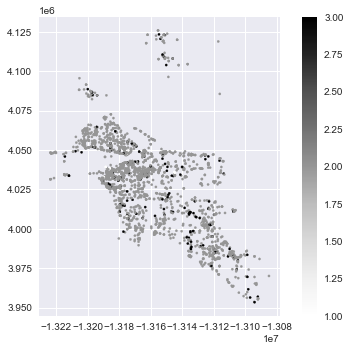

In [697]:
chargers_socal = chargers.loc[chargers.within(poly)]
chargers_socal.reset_index(drop=True, inplace=True)

# same projection with the street network
chargers_socal = chargers_socal.set_crs(epsg=4326)
chargers_socal = chargers_socal.to_crs(G.graph['crs'])

chargers_socal.plot(markersize = 5, column = 'Connections_0_LevelID', legend = True);

projection, both graph and charger table should have the same crs

In [1110]:
G.graph['crs']

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [1111]:
chargers_socal.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## EVCS KDE plot

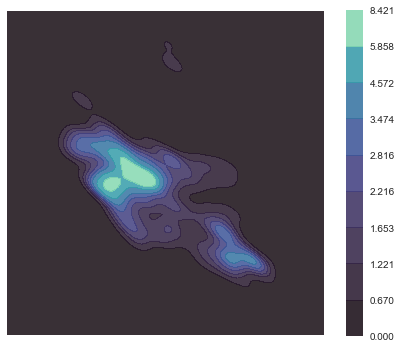

In [698]:
# kde plot, showing density of chargers in the study area and aggregate level sets
geoplot.kdeplot(
    chargers_socal.to_crs(epsg=4326), 
    cmap='mako', alpha=0.85, shade=True, shade_lowest=True, 
    cbar=True, levels=10, bw_adjust=0.7);

## Finding all nearest nodes to the EV chargers

In [1112]:
nearest_node_ids = []

for index, row in chargers_socal.iterrows():
    ev_node = (row['geometry'].y, row['geometry'].x)
    nearest_node_ids.append(ox.get_nearest_node(G, ev_node, method = 'euclidean')) # method on projected graph

In [1113]:
# should return unique ids
nearest_node_ids[0:10]

[1309, 1278, 1260, 1294, 1316, 1295, 1295, 1316, 1266, 1295]

## Approximating Centrality Measures of EVCS

In [1117]:
# some overlaps found among the found nearest node ids, which means some EVCS share the same nearest node
len(nearest_node_ids), len(np.unique(np.array(nearest_node_ids)))

(2421, 1076)

In [1125]:
len(nearest_node_ids), len(evcs_ids)

(2421, 2421)

In [1129]:
evcs_bc = {}
evcs_cc = {}
evcs_dc ={}

for i in np.arange(len(nearest_node_ids)):
    evcs_id = evcs_ids[i]
    node_id = nearest_node_ids[i]
    evcs_bc[evcs_id] = extended_stats_G["betweenness_centrality"][node_id]
    evcs_cc[evcs_id] = extended_stats_G["closeness_centrality"][node_id]
    evcs_dc[evcs_id] = extended_stats_G["degree_centrality"][node_id]

In [1149]:
chargers_socal.shape, type(chargers_socal)

((2421, 9), geopandas.geodataframe.GeoDataFrame)

In [1147]:
chargers_socal['betweenness_centrality'] = list(evcs_bc.values())
chargers_socal['closeness_centrality'] = list(evcs_cc.values())
chargers_socal['degree_centrality'] = list(evcs_dc.values())

In [1148]:
chargers_socal.head()

ID AddressInfo_Postcode  Connections_0_LevelID  Connections_0_PowerKW  \
0  139561                90241                      2                    3.0   
1    4841                90241                      2                    3.0   
2   75793                90723                      2                    3.0   
3  121989                90241                      2                    3.7   
4  139551                90241                      2                    3.0   

   Connections_0_Quantity                           geometry  \
0                     2.0  POINT (-13150927.752 4022419.156)   
1                     4.0  POINT (-13151894.228 4021593.974)   
2                     2.0  POINT (-13150584.777 4020982.831)   
3                     4.0  POINT (-13152527.636 4021727.897)   
4                     2.0  POINT (-13150084.273 4020856.149)   

   betweenness_centrality  closeness_centrality  degree_centrality  
0                0.013426              0.000022           0.000994  
1                0.010180              0.000021           0.000994  
2                0.022674              0.000021           0.001988  
3                0.010138              0.000021           0.000994  
4                0.012622              0.000021           0.001988

## Adding EVCS as nodes to Street Network

In [385]:
# all nodes id in the road network
node_ids = list(G.nodes)
G.nodes[node_ids[20]]

{'osmid_original': 780419146,
 'y': 3960921.305973796,
 'x': -13097968.172201902,
 'ref': '81',
 'highway': 'motorway_junction',
 'street_count': 3,
 'lon': -117.66105,
 'lat': 33.4929664}

In [386]:
type(node_ids[0]), type(chargers_socal.loc[0]['ID'])

(int, numpy.int64)

- checking the number of duplidate node ids with EV charger IDs

In [387]:
num_dup_ids = 0
for index, row in chargers_socal.iterrows():
    if row['ID'] in node_ids:
        num_dup_ids += 1
        print(row['ID'])
num_dup_ids # found duplidates

2501
2609
2407
2389
2443
2442
2441
2608
2562
2591
2539
2573
2530
2490
2576
2566
2491
2554
2598
2925
2499
2537
2544
2543
2509


25

### Define unique EVCS id

In [1126]:
evcs_ids = []
for index, row in chargers_socal.iterrows():
    evcs_ids += ['evcs-' + str(row['ID'])]

In [1127]:
evcs_ids[:7]

['evcs-139561',
 'evcs-4841',
 'evcs-75793',
 'evcs-121989',
 'evcs-139551',
 'evcs-2501',
 'evcs-121991']

In [1128]:
len(evcs_ids)

2421

- adding EV chargers as nodes 
- appended 'ev_charger' node property for later filtering use

In [393]:
for index, row in chargers_socal.iterrows():
    G.add_node(evcs_id[index], y=row['geometry'].y, x=row['geometry'].x, ev_charger='yes')

In [395]:
# test for a known EV charger node
G.nodes['evcs-139561']

{'y': 4022419.1561405594, 'x': -13150927.752029857, 'ev_charger': 'yes'}

## Adding Edges from EVCS nodes to its Nearest Neighbor Street Network Node

The edges between EVCS and its nearest street network node is given its straight line haversine distance, and the node ids are also used as edge ids

In [396]:
# the default street network is not weighted, ignore when adding edges
nx.is_weighted(G) 

False

In [397]:
# sample edge data of the network
G.get_edge_data(14840398, 1846221722) # length in meters

In [398]:
# use the parsed array of nearest node ids in the street network to connect to as new edges. 
for index, row in chargers_socal.iterrows():
    ev_node = (row['geometry'].x, row['geometry'].y)
    ev_node_id = evcs_id[index]    #row['ID']
    
    node_id = nearest_node_ids[index]
    nx_node = (G.nodes[node_id]['x'], G.nodes[node_id]['y'])
    
    length = hs.haversine(ev_node, nx_node, unit=Unit.METERS)
    
    G.add_edge(ev_node_id, node_id, key=ev_node_id, length=length) # use EV charger ID as edge key

---

### Plot the appended network

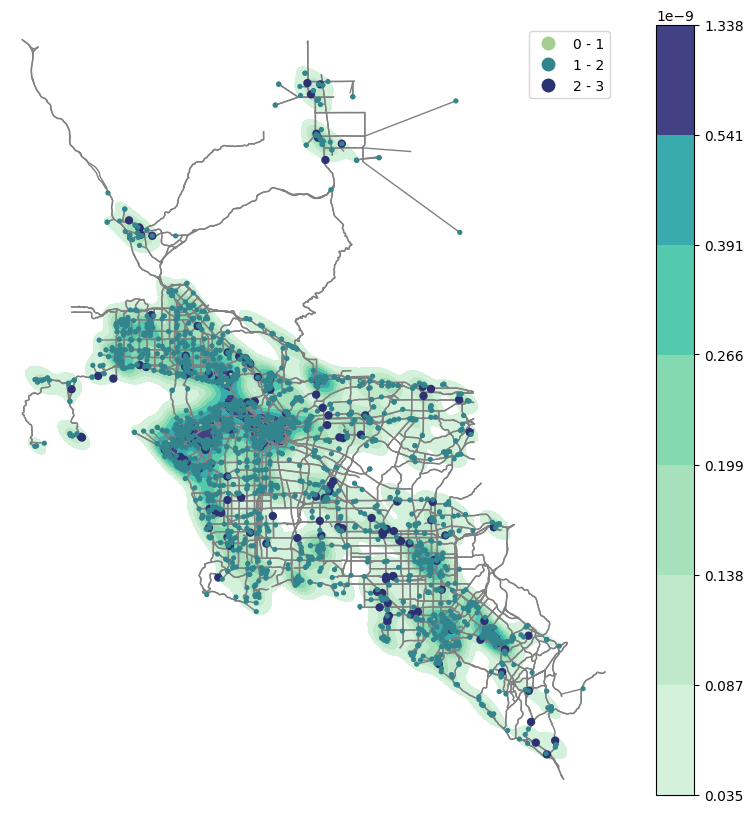

In [708]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 10))

#cax = fig.add_axes([0.2, 0.15, 0.02, 0.3])
#sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=1, vmax=3))
#cbr = fig.colorbar(sm, cax=cax)
#cbr.ax.tick_params(labelsize=10)

scheme = mc.UserDefined(chargers_socal['Connections_0_LevelID'], bins=[1, 2, 3])

geoplot.kdeplot(
    chargers_socal['geometry'], 
    cmap='mako_r', shade=True, 
    shade_lowest=False, cbar=True, levels=8, 
    bw_adjust=0.3, 
    ax=ax
);

geoplot.pointplot(
    chargers_socal,
    hue='Connections_0_LevelID', scheme=scheme,
    cmap='crest',
    legend=True,
    scale='Connections_0_LevelID',
    limits=(0.5, 5),
    ax=ax,
    zorder=10
);


#chargers_socal.plot(ax=ax, markersize = 20, column = 'Connections_0_LevelID', legend = False, alpha=1, cmap='plasma');
ox.plot_graph(G, ax=ax, edge_color="grey", node_size=0);

## Network basic stats

In [409]:
nodes_proj = ox.graph_to_gdfs(G, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print('network area = ', graph_area_m, 'm^2')
ox.basic_stats(G, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')
# reduced the network complexity by a factor of ~10 after consolidation

network area =  18624281838.374893 m^2


{'n': 6580,
 'm': 11426,
 'k_avg': 3.4729483282674773,
 'intersection_count': 2152,
 'streets_per_node_avg': 0.9996960486322188,
 'streets_per_node_counts': {0: 0, 1: 0, 2: 29, 3: 1989, 4: 120, 5: 11, 6: 3},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.0,
  2: 0.004407294832826748,
  3: 0.30227963525835866,
  4: 0.0182370820668693,
  5: 0.0016717325227963526,
  6: 0.0004559270516717325},
 'edge_length_total': 25784876270.780647,
 'edge_length_avg': 2256684.427689537,
 'street_length_total': 25782752128.03422,
 'street_length_avg': 2521047.436006084,
 'street_segments_count': 10227,
 'node_density_km': 0.35330221358882496,
 'intersection_density_km': 0.11554807958102603,
 'edge_density_km': 1384476.271060907,
 'street_density_km': 1384362.2187304678,
 'circuity_avg': 1898.8681753133178,
 'self_loop_proportion': 0.00017503938386136881,
 'clean_intersection_count': 6031,
 'clean_intersection_density_km': 0.3238245668927361}

In [410]:
# write to save appended network, run only once
#os.getcwd()
#ox.save_graphml(G, 'data/socal_street_network_consolidated_w_chargers.graphml')

## Add a Basemap

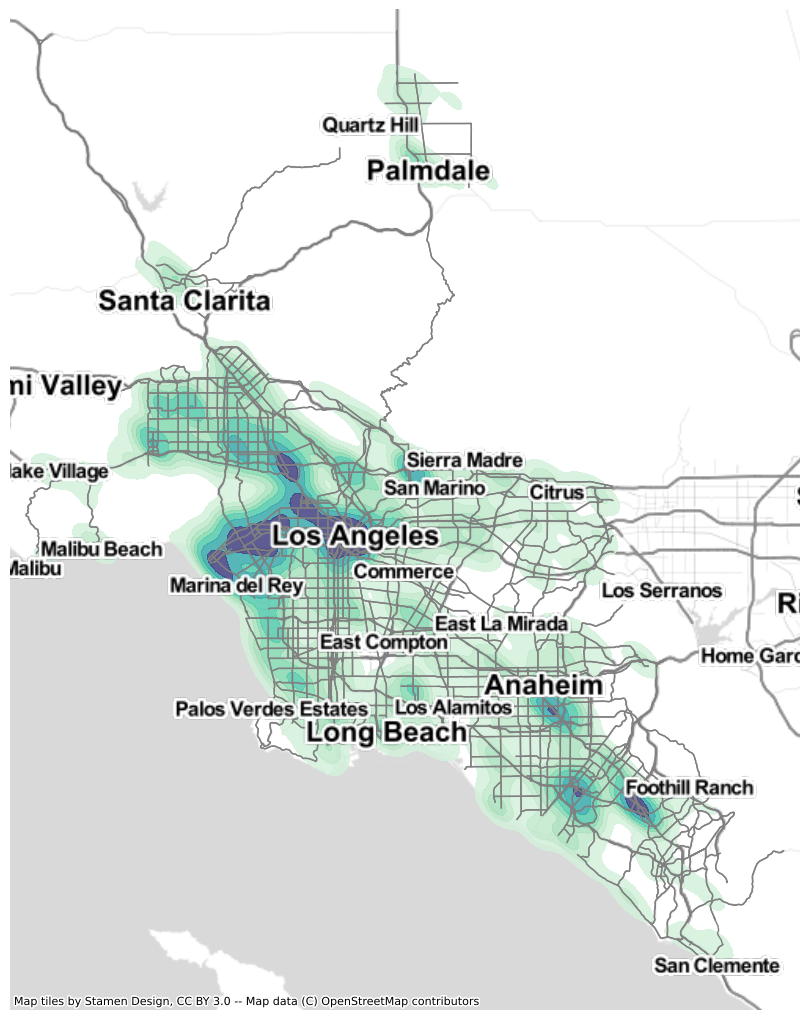

In [1535]:
fig, ax = plt.subplots(figsize=(13, 13))

scheme = mc.UserDefined(chargers_socal_wm['Connections_0_LevelID'], bins=[1, 2, 3])

chargers_socal_wm.plot(ax=ax, markersize=0, column='Connections_0_LevelID', legend=False, alpha=1, cmap='plasma');
cx.add_basemap(ax, zoom=9, source=cx.providers.Stamen.TonerLite, zorder=0);
cx.add_basemap(ax, zoom=9, source=cx.providers.Stamen.TonerLabels, zorder=1);

x, y = poly.exterior.xy
ax.plot(x, y, zorder=10)

geoplot.kdeplot(
    chargers_socal_wm['geometry'], 
    cmap='mako_r', alpha=0.85, shade=True, 
    shade_lowest=False, cbar=False, levels=8, 
    bw_adjust=0.3, 
    ax=ax, zorder=1
);

# geoplot.pointplot(
#     chargers_socal_wm,
#     hue='Connections_0_LevelID', scheme=scheme,
#     legend=True,
#     ax=ax,
#     legend_kwargs={'title': 'EVCS Levels'}
# );


ox.plot_graph(G, ax=ax, edge_color="grey", node_size=0);
fig.savefig('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork/plot/SoCalEVCS_kde_only_basemap.png', dpi=300)

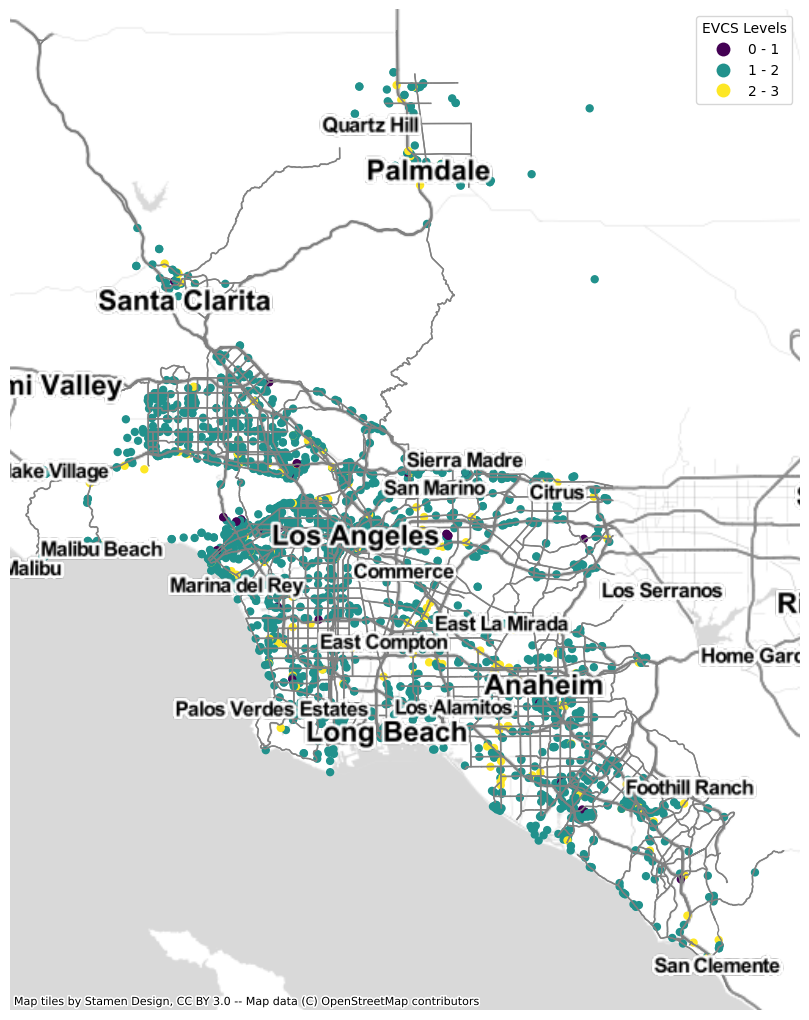

In [1534]:
fig, ax = plt.subplots(figsize=(13, 13))

scheme = mc.UserDefined(chargers_socal_wm['Connections_0_LevelID'], bins=[1, 2, 3])

chargers_socal_wm.plot(ax=ax, markersize=0, column='Connections_0_LevelID', legend=False, alpha=1, cmap='plasma');
cx.add_basemap(ax, zoom=9, source=cx.providers.Stamen.TonerLite, zorder=0);
cx.add_basemap(ax, zoom=9, source=cx.providers.Stamen.TonerLabels, zorder=1);

x, y = poly.exterior.xy
ax.plot(x, y, zorder=10)

# geoplot.kdeplot(
#     chargers_socal_wm['geometry'], 
#     cmap='mako_r', alpha=0.85, shade=True, 
#     shade_lowest=False, cbar=False, levels=8, 
#     bw_adjust=0.3, 
#     ax=ax, zorder=1
# );

geoplot.pointplot(
    chargers_socal_wm,
    hue='Connections_0_LevelID', scheme=scheme,
    legend=True,
    ax=ax,
    legend_kwargs={'title': 'EVCS Levels'}
);


ox.plot_graph(G, ax=ax, edge_color="grey", node_size=0);
fig.savefig('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork/plot/SoCalEVCS_only_basemap.png', dpi=300)

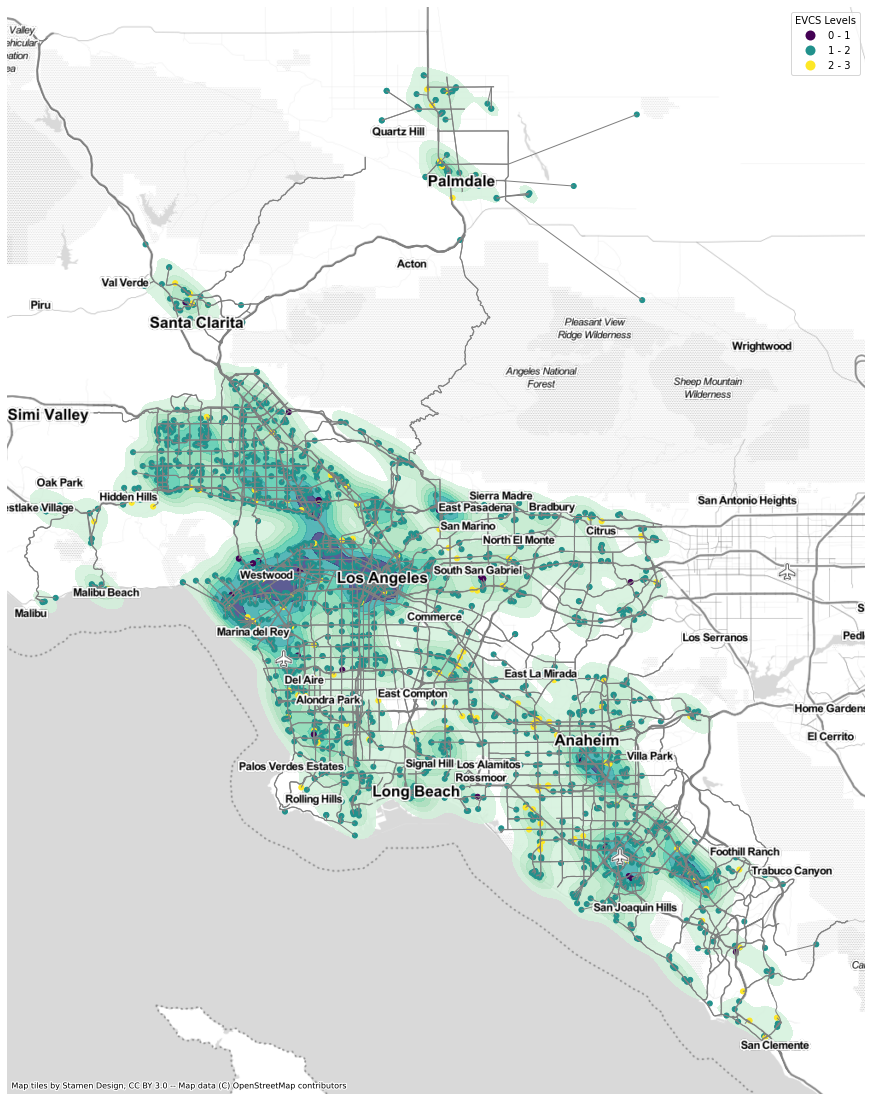

In [443]:
fig, ax = plt.subplots(figsize=(20, 20))

scheme = mc.UserDefined(chargers_socal_wm['Connections_0_LevelID'], bins=[1, 2, 3])

chargers_socal_wm.plot(ax=ax, markersize=0, column='Connections_0_LevelID', legend=False, alpha=1, cmap='plasma');
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLite, zorder=0);
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLabels, zorder=1);

x, y = poly.exterior.xy
ax.plot(x, y, zorder=10)

geoplot.kdeplot(
    chargers_socal_wm['geometry'], 
    cmap='mako_r', alpha=0.85, shade=True, 
    shade_lowest=False, cbar=False, levels=8, 
    bw_adjust=0.3, 
    ax=ax, zorder=1
);

geoplot.pointplot(
    chargers_socal_wm,
    hue='Connections_0_LevelID', scheme=scheme,
    legend=True,
    ax=ax,
    legend_kwargs={'title': 'EVCS Levels'}
);


ox.plot_graph(G, ax=ax, edge_color="grey", node_size=0);
fig.savefig('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork/plot/SoCalEVCS_kde_basemap.png', dpi=300)

# Initial Analysis of the network

In [197]:
# average shortest path length
nx.average_shortest_path_length(G)

KeyboardInterrupt: 

node degree historgam 

/Users/jarvis/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


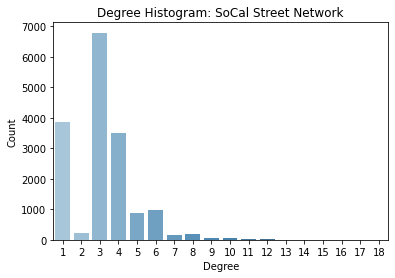

In [37]:
# creating degree histogram

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

ax = sns.barplot(list(deg), list(cnt), palette="Blues_d")

plt.title("Degree Histogram: SoCal Street Network")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

shortest path distribution using physical length as weights

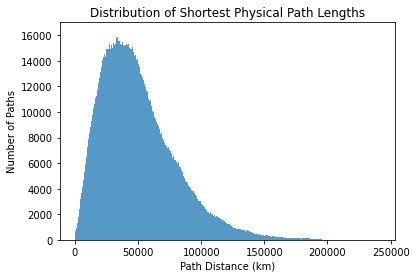

In [38]:
# Shortest physical path length (m)

lengths = nx.shortest_path_length(G, weight='length')
plengths=[]
for key in lengths:   # iterates all the lengths
   ll = key
   for i in list(ll[1].values()):    # saves a list with the lengths greater than zero
      if i > 0:
        plengths.append(i)

sns.histplot(x=plengths, binwidth=5000);
plt.xlabel("Path Distance (m)");
plt.ylabel("Number of Edges");
plt.title("Shortest Path Lengths (m): SoCal Street Network");

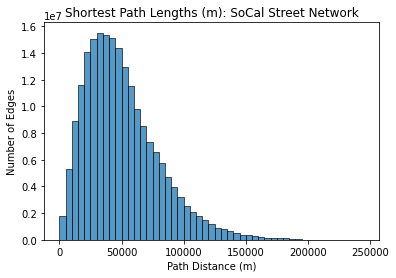

In [45]:
sns.histplot(x=plengths, binwidth=5000);
plt.xlabel("Path Distance (m)");
plt.ylabel("Number of Edges");
plt.title("Shortest Path Lengths (m): SoCal Street Network");

shortest path distribution

In [ ]:
lengths = nx.shortest_path_length(G)
plengths=[]
for key in lengths:   #iterates all the lengths
   ll = key
   for i in list(ll[1].values()):    #saves a list with the lengths greater than zero
      if i > 0:
        plengths.append(i)

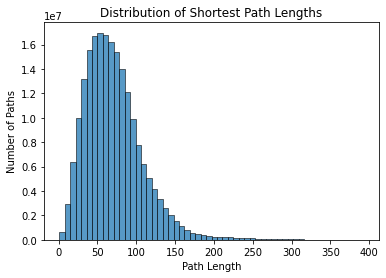

In [51]:
sns.histplot(x=plengths, binwidth=7);
plt.xlabel("Path Length");
plt.ylabel("Number of Paths");
plt.title("Distribution of Shortest Path Lengths");

In [46]:
# G is created as a Multi-DiGraph
# in order to calculate the average clustering, we need to convert it into a DiGraph object

H = nx.DiGraph(G)
H

In [48]:
nx.average_clustering(H)

0.026920664639611288

## Small world?
- we are interested to see if the SoCal EVCS Network resembles a small world network

1. extract network properties

In [53]:
num_nodes = H.number_of_nodes()
num_edges = H.number_of_edges()
c = nx.average_clustering(H)
k = np.mean(list(dict(H.degree()).values()))
l = nx.average_shortest_path_length(H)
n = int(num_nodes)

In [64]:
n, num_edges, k, l

(16753, 26032, 3, 51.61825509263163)

In [60]:
k_int = int(np.mean(list(dict(H.degree()).values())))

2. create a watts strogatz graph with same network property

In [68]:
watts_strogatz_c0 = nx.watts_strogatz_graph(n, k_int, 0)
print("C(0) =" , nx.average_clustering(watts_strogatz_c0))

c_0 = nx.average_clustering(watts_strogatz_c0)+0.001

c_p = nx.average_clustering(H)
p = -(c_p/c_0)**(1/3)+1

print(n, k, p)
watts_strogatz = nx.watts_strogatz_graph(n, k, p, seed=123)

C(0) = 0.0
16753 3 -1.9970587706512823


In [70]:
watts_strogatz = nx.watts_strogatz_graph(n, k, 0.5, seed=123)

In [ ]:
num_nodes_ws = watts_strogatz.number_of_nodes()
num_edges_ws = watts_strogatz.number_of_edges()
c_ws = nx.average_clustering(watts_strogatz)
k_ws = np.mean(list(dict(watts_strogatz.degree()).values()))
l_ws = nx.average_shortest_path_length(watts_strogatz)

In [72]:
socal = ['SoCal Street Network', num_nodes, num_edges, c, k, l]
ws = ['Small World Network Model', num_nodes_ws, num_edges_ws, c_ws, k_ws, l_ws]
df = pd.DataFrame(columns =['network', '#nodes', '#links', '<C>', '<K>', '<L>'])
df.loc[0] = socal
df.loc[1] = ws
df.set_index('network')

#nodes #links       <C>  <K>         <L>
network                                                           
SoCal Street Network       16753  26032  0.026921    3   51.618255
Small World Network Model  16753  16753  0.000000  2.0  192.015645

---

# CA Zipcode Filtering
- for census clustering and LEHD traffic flow analysis

<AxesSubplot:>

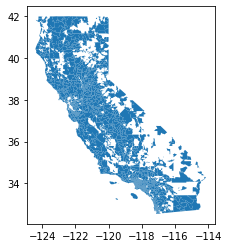

In [452]:
ca_zip = gpd.read_file('data/ca_zipcodes_shapes/tl_2010_06_zcta510.shp')
ca_zip.plot()

<AxesSubplot:>

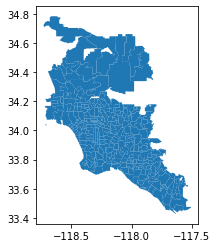

In [453]:
socal_zip = ca_zip.loc[ca_zip.within(poly)]
socal_zip.plot()

change projection to match that of the network

In [454]:
socal_zip_proj = socal_zip.to_crs(G.graph['crs'])

In [472]:
socal_zip.head()

STATEFP10 ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
54        06     91504  0691504        B5   G6350          S  12783282   
55        06     91606  0691606        B5   G6350          S   8631179   
56        06     90640  0690640        B5   G6350          S  21990769   
57        06     91770  0691770        B5   G6350          S  16634980   
59        06     90290  0690290        B5   G6350          S  51935407   

    AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
54     29685  +34.2045683  -118.3263651         N   
55     25464  +34.1857670  -118.3883235         N   
56    104151  +34.0154437  -118.1110124         N   
57    138149  +34.0654930  -118.0845292         N   
59     24096  +34.1077280  -118.6159812         N   

                                             geometry  
54  POLYGON ((-118.34858 34.20846, -118.34856 34.2...  
55  POLYGON ((-118.40307 34.19394, -118.40256 34.1...  
56  POLYGON ((-118.12834 33.98589, -118.12736 33.9...  
57  POLYGON ((-118.10729 34.06622, -118.10732 34.0...  
59  POLYGON ((-118.64064 34.12582, -118.64013 34.1...

creating a list of zipcodes in the study area 

In [473]:
socal_zip_lst = socal_zip['ZCTA5CE10'].unique().tolist()

In [457]:
# write to file
# socal_zip.to_file("data/ca_zipcodes_shapes/socal_zip.shp")
# socal_zip_proj.to_file("data/ca_zipcodes_shapes/socal_zip_proj.shp")
#socal_zip.to_csv("data/ca_zipcodes_shapes/socal_zip.csv")

---

# EV Registration

In [475]:
ca_veh = pd.read_csv('data/vehicle-count-as-of-1-1-2020.csv')

In [470]:
sum(ca_veh[ca_veh['Make'] == 'TESLA']['Vehicles'])/(sum(ca_veh['Vehicles']))

0.005651370255742801

In [471]:
ca_veh['Fuel'].unique()

array(['Gasoline', 'Natural Gas', 'Diesel and Diesel Hybrid', 'Flex-Fuel',
       'Hybrid Gasoline', 'Other', 'Battery Electric',
       'Hydrogen Fuel Cell', 'Plug-in Hybrid'], dtype=object)

In [474]:
socal_veh = ca_veh[ca_veh['Zip Code'].isin(socal_zip_lst)]
socal_veh.head()

Date Zip Code Model Year      Fuel   Make   Duty  Vehicles
0  1/1/2020    90001       2007  Gasoline  ACURA  Light        15
1  1/1/2020    90002       2007  Gasoline  ACURA  Light        20
2  1/1/2020    90003       2007  Gasoline  ACURA  Light        29
3  1/1/2020    90004       2007  Gasoline  ACURA  Light        19
4  1/1/2020    90006       2007  Gasoline  ACURA  Light        15

ca and socal TESLA vehicle percent share

In [478]:
ca_tsla_pct = sum(ca_veh[ca_veh['Make'] == 'TESLA']['Vehicles'])/(sum(ca_veh['Vehicles']))
socal_tsla_pct = sum(socal_veh[socal_veh['Make'] == 'TESLA']['Vehicles'])/(sum(socal_veh['Vehicles']))

ca_tsla_pct * 100, socal_tsla_pct * 100

(0.5651370255742801, 0.6565636069546463)

EV share piechart

In [481]:
fleet_size = [sum(ca_veh[ca_veh['Fuel'] == fuel]['Vehicles']) for fuel in ca_veh['Fuel'].unique()]
fleet_size

[26985319, 29096, 1271338, 1257292, 1123090, 5867, 306803, 6648, 248388]

In [498]:
type(ca_veh['Model Year'][0])

int

In [509]:
ca_veh['Model Year'].unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       '2017', '2018', '2019', '2020', '2021', '<2007', 'Unk'],
      dtype=object)

In [511]:
ca_veh['Model Year > 2007'] = ca_veh['Model Year'].replace('<2007', 0)
ca_veh['Model Year > 2007'] = ca_veh['Model Year > 2007'].replace('Unk', 0)
ca_veh['Model Year > 2007'] = list(map(int, ca_veh['Model Year > 2007']))

ca_veh_2007 = ca_veh[ca_veh['Model Year > 2007'] >= 2007]

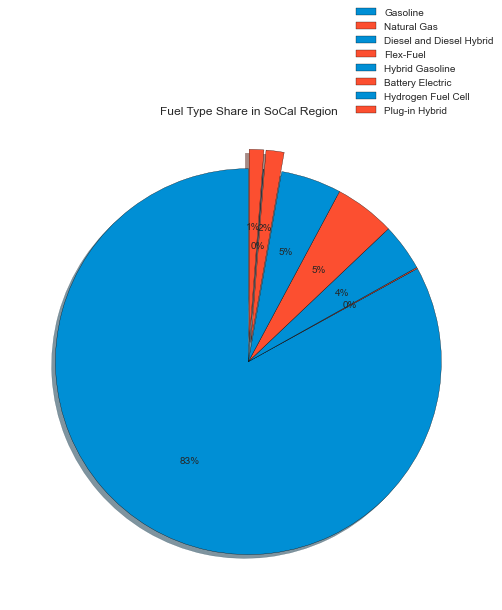

In [515]:
plt.style.use('seaborn')

fig, ax = plt.subplots(nrows=1, ncols=1)

labels = 'Gasoline', 'Natural Gas', 'Diesel and Diesel Hybrid', 'Flex-Fuel', 'Hybrid Gasoline', 'Battery Electric', 'Hydrogen Fuel Cell', 'Plug-in Hybrid'
colors = ['#008fd5', '#fc4f30']
explode = (0, 0, 0, 0, 0, 0.1, 0, 0.1)

plt.title('Fuel Type Share in SoCal Region')
plt.tight_layout()

fleet_size = [sum(ca_veh_2007[ca_veh_2007['Fuel'] == fuel]['Vehicles']) for fuel in labels]


ax.pie(fleet_size, startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', explode=explode, shadow=True)



#fig.suptitle('Public Opinion on CTQ-measures', fontsize=20, y=1.07, fontweight='bold', x=0.37)
fig.set_figheight(10)
fig.set_figwidth(7)
fig.legend(labels=labels, fontsize='medium')
fig.tight_layout()

#fig.savefig('Opinions_ctq')

plt.show()

----

## EVCS and Census Clustering

Goals:

1. Select revelant census variables for clustering exploration, in addition to the selected attributes of the EVCS
2. Extract census data on the census tract level for the two major counties in the study region, LA County and Orange County, CA
3. Combine their census dataframe together geo-spatially, and clip within the custom bbox to keep the analysis consistency
4. Spatially interpolate the EVCS data with the census data where it lands, each charging station thus represent the census demographics of the tracts that they belong. We expect there will be nodes falling into the same tracts thus having repetition of the census datas, but it is not a concern for the analysis given the large amount of both census tracts & EVCS within the SoCal region.
5. Since we have a total 3000+ EVCS nodes in the study area, we are able to run a K-means algorithm to cluster the EVCS based on their charging attributes AND census attributes, which would further provide insights on who and how these EVCS serve its population.
6. Combined with traffic/commute flow and the clustering of the census tracts themselves providing a background, we hope to extract more insights on the performance of the EVCS within the SoCal study area.

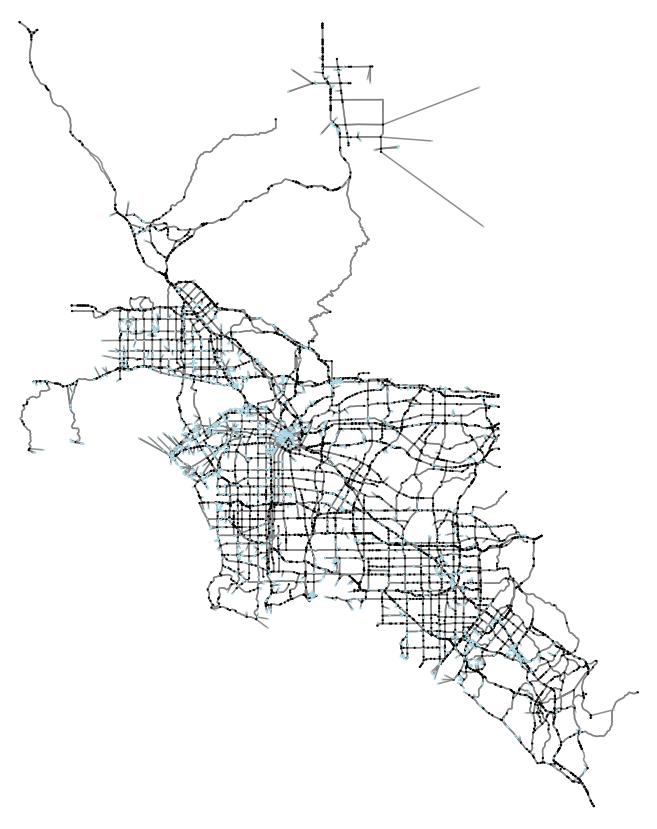

In [653]:
nc = ['lightblue' if 'ev_charger' in list(node_dict[n].keys()) else 'black' for n in G.nodes]


fig, ax = ox.plot_graph(
    G, 
    bgcolor="white", edge_color='grey', 
    node_color=nc, node_size=5, 
    figsize=(15, 15),
    edge_linewidth=1.5,
    edge_alpha=0.9
)

## Loading ACS 2019 Data with Selected Variables

In [1325]:
vars_to_download = {
    "B08013_001E": "agg_travel_time",     # Aggregate travel time to work (in minutes)
    "B08012_008E": "30-34_min",
    "B08012_011E": "45-49_min",
    "B09019_001E": "hh_total",            # Total households
    "B01001I_001E": "total_hispanic",     # Total hispanic population     
    "B08014_001E": "total_veh_available", # Average number of vehicle available
    "B02001_003E": "total_pop_black",     # Total black pop
    "B02001_005E": "total_pop_asian",     # Total asian pop
    "B02001_002E": "total_pop_white",     # Total white pop
    "B01003_001E": "total_pop",           # Total population
    "B15003_002E": "total_bachelor",      # Total w/ Bachelor degree
    "B01002_001E": "median_age",          # Median age
    "B19013_001E": "median_hh_income",    # Median household income 
    "B08015_001E": "access_to_vehicle"    # Workers over age 16 that drove alone to work by car, van, truck
}
vars_to_download_l = list(vars_to_download.keys())

In [1326]:
acs = cp.products.ACS(2019)

In [1327]:
la_data = acs.from_county('Los Angeles County, CA', 
                          level="tract",
                          variables=vars_to_download_l
                         )

In [1328]:
oc_data = acs.from_county('Orange County, CA', 
                          level="tract",
                          variables=vars_to_download_l
                         )

In [1329]:
var_names = acs.variables\
               .reindex(vars_to_download)\
               [["label", "concept"]]\
               .reset_index()\
               .rename(columns={"index": "var_id"})
var_names["short_name"] = var_names["var_id"].map(vars_to_download)

In [1330]:
# create filler and fill in the nan values with column mean

filler = lambda col: col.fillna(col.mean())
la_data.loc[:, vars_to_download] = la_data.loc[:, vars_to_download].apply(filler)
oc_data.loc[:, vars_to_download] = oc_data.loc[:, vars_to_download].apply(filler)

In [1331]:
# concatenate the two tables which should cover the most of the study region 

socal_data = pd.concat([la_data, oc_data])
print(type(socal_data))
socal_data = socal_data.rename(columns=vars_to_download)
socal_data.head(1)

<class 'geopandas.geodataframe.GeoDataFrame'>


GEOID                                           geometry  \
0  06037670403  POLYGON ((-13177840.910 3998757.250, -13177839...   

   total_hispanic  median_age  total_pop  total_pop_white  total_pop_black  \
0           116.0        49.5     2733.0           1483.0             26.0   

   total_pop_asian  30-34_min  45-49_min  agg_travel_time  \
0           1068.0       78.0      108.0          36700.0   

   total_veh_available  access_to_vehicle  hh_total  total_bachelor  \
0               1061.0              945.0    2733.0             1.0   

   median_hh_income                                               NAME state  \
0          153667.0  Census Tract 6704.03, Los Angeles County, Cali...    06   

  county   tract  
0    037  670403

## Attributing Variables 

In [1383]:
socal_data['avg_travel_time'] = socal_data['agg_travel_time'] / socal_data['access_to_vehicle']

# percentages
socal_data['pct_white'] = socal_data['total_pop_white'] / socal_data['total_pop'] * 100
socal_data['pct_black'] = socal_data['total_pop_black'] / socal_data['total_pop'] * 100
socal_data['pct_asian'] = socal_data['total_pop_asian'] / socal_data['total_pop'] * 100
socal_data['pct_hispanic'] = socal_data['total_hispanic'] / socal_data['total_pop'] * 100
socal_data['pct_bachelor'] = socal_data['total_bachelor'] / socal_data['total_pop'] * 100
socal_data['pct_access_to_veh'] = socal_data['access_to_vehicle'] / socal_data['total_pop'] * 100
socal_data['pct_30-34_min'] = socal_data['30-34_min'] / socal_data['total_pop'] * 100
socal_data['pct_45-49_min'] = socal_data['45-49_min'] / socal_data['total_pop'] * 100

In [1384]:
socal_data = socal_data.replace([np.inf, -np.inf], np.nan)
socal_data = socal_data.fillna(socal_data.mean())
socal_data.loc[socal_data['pct_access_to_veh'] > 100, 'pct_access_to_veh'] = np.mean(socal_data['pct_access_to_veh'])

In [1385]:
# inspect data

socal_data.describe()

total_hispanic   median_age     total_pop  total_pop_white  \
count     2851.000000  2851.000000   2851.000000      2851.000000   
mean      2038.787092    37.838175   4524.381270      2416.099965   
std       1549.134683     7.065714   1845.087642      1324.121558   
min          0.000000    10.000000      0.000000         0.000000   
25%        764.000000    33.000000   3342.500000      1475.500000   
50%       1691.000000    37.100000   4352.000000      2223.000000   
75%       3040.500000    42.300000   5518.000000      3176.500000   
max       9430.000000    76.100000  23390.000000      9754.000000   

       total_pop_black  total_pop_asian    30-34_min    45-49_min  \
count      2851.000000      2851.000000  2851.000000  2851.000000   
mean        302.086987       728.168011   362.094353   210.514907   
std         531.196100       941.554989   199.015230   120.667910   
min           0.000000         0.000000     0.000000     0.000000   
25%          41.000000       160.500000   227.000000   126.000000   
50%         120.000000       437.000000   337.000000   194.000000   
75%         316.500000       913.000000   463.000000   275.000000   
max        5801.000000     13013.000000  2097.000000  1122.000000   

       agg_travel_time  total_veh_available  ...  median_hh_income  \
count      2851.000000          2851.000000  ...       2851.000000   
mean      64115.729922          2167.666784  ...      77493.979760   
std       26560.173757           939.844321  ...      35469.269726   
min          10.000000             0.000000  ...       9191.000000   
25%       45925.000000          1577.000000  ...      51095.500000   
50%       61715.000000          2067.000000  ...      71042.000000   
75%       78192.500000          2658.500000  ...      95669.500000   
max      296535.000000         11113.000000  ...     250001.000000   

       avg_travel_time    pct_white    pct_black    pct_asian  pct_hispanic  \
count      2851.000000  2851.000000  2851.000000  2851.000000   2851.000000   
mean         38.072700    53.798736     6.809889    15.423955     44.962684   
std          11.081102    20.279081    11.255897    15.828681     28.568205   
min           0.006133     0.000000     0.000000     0.000000      0.000000   
25%          32.515670    37.929443     1.016888     4.434654     18.451847   
50%          36.332192    54.475703     2.790316    10.796515     41.052310   
75%          40.941332    70.677209     7.016928    19.677545     69.765159   
max         288.171875   100.000000    84.708249    87.075575    100.000000   

       pct_bachelor  pct_access_to_veh  pct_30-34_min  pct_45-49_min  
count   2851.000000        2851.000000    2851.000000    2851.000000  
mean       2.274204          38.723383       8.066515       4.709830  
std        2.095484           9.343630       3.372954       2.135091  
min        0.000000           2.129081       0.000000       0.000000  
25%        0.725160          34.156363       5.962626       3.240079  
50%        1.867354          38.675129       7.897153       4.598214  
75%        3.263201          42.667265       9.846583       6.043588  
max       19.799499          96.285868      44.444444      19.230769  

[8 rows x 23 columns]

## Filtering Tracts within study area

In [1386]:
socal_data.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [1387]:
# reproject for filtering with custom polygon

# socal_data = gpd.GeoDataFrame(socal_data, geometry='geometry')
socal_data = socal_data.to_crs(epsg=4327)
socal_data = socal_data.loc[socal_data.within(poly)]
socal_data = socal_data.to_crs(epsg=3857)

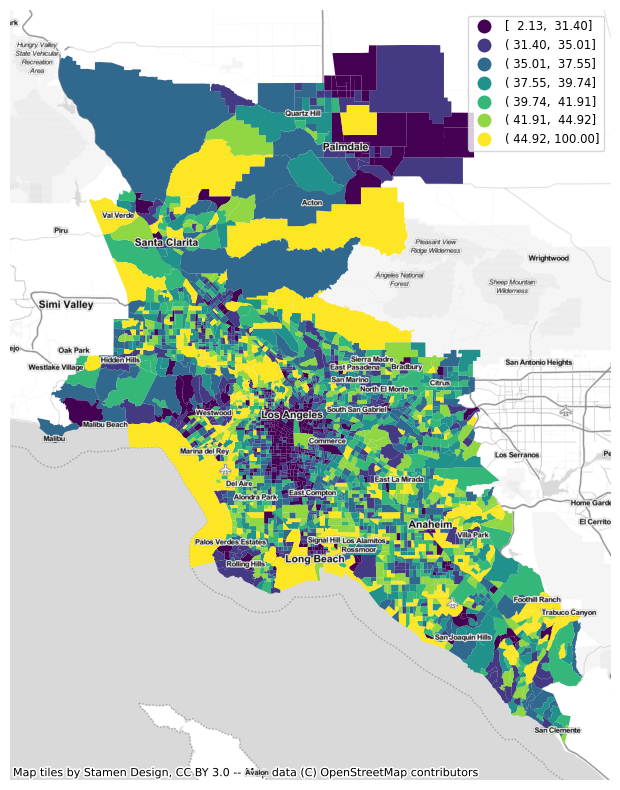

In [1337]:
plt.style.use('default')

ax = socal_data_proj.plot(
    'pct_access_to_veh', 
    legend=True,
    #cmap=,
    figsize=(15, 10), 
    scheme='quantiles', 
    k=7,
    legend_kwds={"fontsize": "small"}
);

cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLite);
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLabels);

ax.axis('off');

## Merging ACS data with EVCS dataframe

In [1388]:
chargers_socal.head()

ID AddressInfo_Postcode  Connections_0_LevelID  Connections_0_PowerKW  \
0  139561                90241                      2                    3.0   
1    4841                90241                      2                    3.0   
2   75793                90723                      2                    3.0   
3  121989                90241                      2                    3.7   
4  139551                90241                      2                    3.0   

   Connections_0_Quantity                           geometry  \
0                     2.0  POINT (-13150927.752 4022419.156)   
1                     4.0  POINT (-13151894.228 4021593.974)   
2                     2.0  POINT (-13150584.777 4020982.831)   
3                     4.0  POINT (-13152527.636 4021727.897)   
4                     2.0  POINT (-13150084.273 4020856.149)   

   betweenness_centrality  closeness_centrality  degree_centrality  
0                0.013426              0.000022           0.000994  
1                0.010180              0.000021           0.000994  
2                0.022674              0.000021           0.001988  
3                0.010138              0.000021           0.000994  
4                0.012622              0.000021           0.001988

In [1389]:
# spatial interpolating each EVCS onto the tract it lands on and merge its columns with the tract census data

chargers_socal_acs = gpd.sjoin(chargers_socal, socal_data, how='left', op='within')
display(chargers_socal_acs.head())
# chargers_socal_acs.plot();

ID AddressInfo_Postcode  Connections_0_LevelID  Connections_0_PowerKW  \
0  139561                90241                      2                    3.0   
1    4841                90241                      2                    3.0   
2   75793                90723                      2                    3.0   
3  121989                90241                      2                    3.7   
4  139551                90241                      2                    3.0   

   Connections_0_Quantity                           geometry  \
0                     2.0  POINT (-13150927.752 4022419.156)   
1                     4.0  POINT (-13151894.228 4021593.974)   
2                     2.0  POINT (-13150584.777 4020982.831)   
3                     4.0  POINT (-13152527.636 4021727.897)   
4                     2.0  POINT (-13150084.273 4020856.149)   

   betweenness_centrality  closeness_centrality  degree_centrality  \
0                0.013426              0.000022           0.000994   
1                0.010180              0.000021           0.000994   
2                0.022674              0.000021           0.001988   
3                0.010138              0.000021           0.000994   
4                0.012622              0.000021           0.001988   

   index_right  ...   tract  avg_travel_time  pct_white  pct_black  pct_asian  \
0       1981.0  ...  550800        37.507692  71.444009   0.742942   5.916520   
1       1975.0  ...  551402        36.647500  61.364122   4.639726   5.687406   
2       1110.0  ...  550901        41.035928  65.563873   3.018595   8.741850   
3       1981.0  ...  550800        37.507692  71.444009   0.742942   5.916520   
4       1110.0  ...  550901        41.035928  65.563873   3.018595   8.741850   

   pct_hispanic  pct_bachelor  pct_access_to_veh  pct_30-34_min  pct_45-49_min  
0     79.022018      3.620154          39.511009       8.955829       6.038093  
1     72.567885      1.325636          42.762455       8.210391       5.986744  
2     72.856798      0.941801          40.328423       8.452065       4.998793  
3     79.022018      3.620154          39.511009       8.955829       6.038093  
4     72.856798      0.941801          40.328423       8.452065       4.998793  

[5 rows x 38 columns]

In [1390]:
# number of unique EVCS in SoCal

len(chargers_socal['ID'].unique())

2421

In [1391]:
# number of unique census tract in SoCal

len(socal_data['tract'].unique())

2851

In [1392]:
len(chargers_socal_acs['tract'].unique()) / len(socal_data['tract'].unique()) * 100

33.00596282006313

After spatial interpolating the EVCS onto the the census tract they land on, we are left with 32.5% of the unique census tracts in the SoCal region

In [1393]:
# writing to file for later use

socal_data.to_file("data/socal_acs.geojson", driver='GeoJSON')
chargers_socal_acs.to_file("data/chargers_socal_acs.geojson", driver='GeoJSON')

# EVCS K-Means Clusterings

In [1394]:
chargers_socal_acs.columns

Index(['ID', 'AddressInfo_Postcode', 'Connections_0_LevelID',
       'Connections_0_PowerKW', 'Connections_0_Quantity', 'geometry',
       'betweenness_centrality', 'closeness_centrality', 'degree_centrality',
       'index_right', 'GEOID', 'total_hispanic', 'median_age', 'total_pop',
       'total_pop_white', 'total_pop_black', 'total_pop_asian', '30-34_min',
       '45-49_min', 'agg_travel_time', 'total_veh_available',
       'access_to_vehicle', 'hh_total', 'total_bachelor', 'median_hh_income',
       'NAME', 'state', 'county', 'tract', 'avg_travel_time', 'pct_white',
       'pct_black', 'pct_asian', 'pct_hispanic', 'pct_bachelor',
       'pct_access_to_veh', 'pct_30-34_min', 'pct_45-49_min'],
      dtype='object')

In [1395]:
# Selecting columns as clustering variables

cluster_var = ['Connections_0_LevelID', 'Connections_0_PowerKW', 'Connections_0_Quantity', 
               'betweenness_centrality', 'closeness_centrality', 'degree_centrality',
               'median_age', 'median_hh_income', 'total_pop', 'hh_total',
               'avg_travel_time', 'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic',
               'pct_bachelor', 'pct_access_to_veh', 
               'pct_30-34_min', 'pct_45-49_min']

cluster_var_acs_socal = ['median_age', 'median_hh_income', 
                         'avg_travel_time', 'pct_white', 'pct_black', 'pct_asian', 'total_pop',
                         'pct_bachelor', 'pct_access_to_veh', 
                         'pct_30-34_min', 'pct_45-49_min']

In [1396]:
# clear out NaN and inf values and replace with column mean

chargers_socal_acs = chargers_socal_acs.replace([np.inf, -np.inf], np.nan)
chargers_socal_acs = chargers_socal_acs.fillna(chargers_socal_acs.mean())

# number of rows with nan values

chargers_socal_acs_kmeans.isnull().values.ravel().sum()

0

In [1397]:
chargers_socal_acs_kmeans = chargers_socal_acs[cluster_var]

K = range(1, 12)
wss = []

for k in K:
    kmeans=cluster.KMeans(n_clusters=k,init="k-means++")
    kmeans=kmeans.fit(
        chargers_socal_acs_kmeans.replace([np.inf, -np.inf], np.nan).fillna(chargers_socal_acs_kmeans.mean()
                                                                           )
    )
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

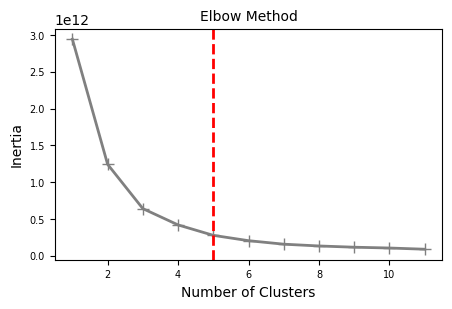

In [1398]:
# Using elbow method to select the correct number of clusters

plt.figure(figsize = (5, 3))
plt.plot(range(1,12), wss, linewidth = 2, color = 'grey', marker='+', markersize = 8)
plt.title('Elbow Method', fontsize = 10)
plt.xlabel('Number of Clusters',fontsize = 10)
plt.ylabel('Inertia',fontsize = 10)

n_clusters = 5
plt.axvline(x = n_clusters, linewidth = 2, color = 'red', linestyle = '--')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

In [1399]:
# create slices of geodataframe for both the spatial-joined EVCS and SoCal ACS data

chargers_socal_acs_kmeans = chargers_socal_acs[cluster_var + ['geometry']]
socal_data_kmeans = socal_data[cluster_var_acs_socal + ['geometry']]

In [1400]:
len(cluster_var)

19

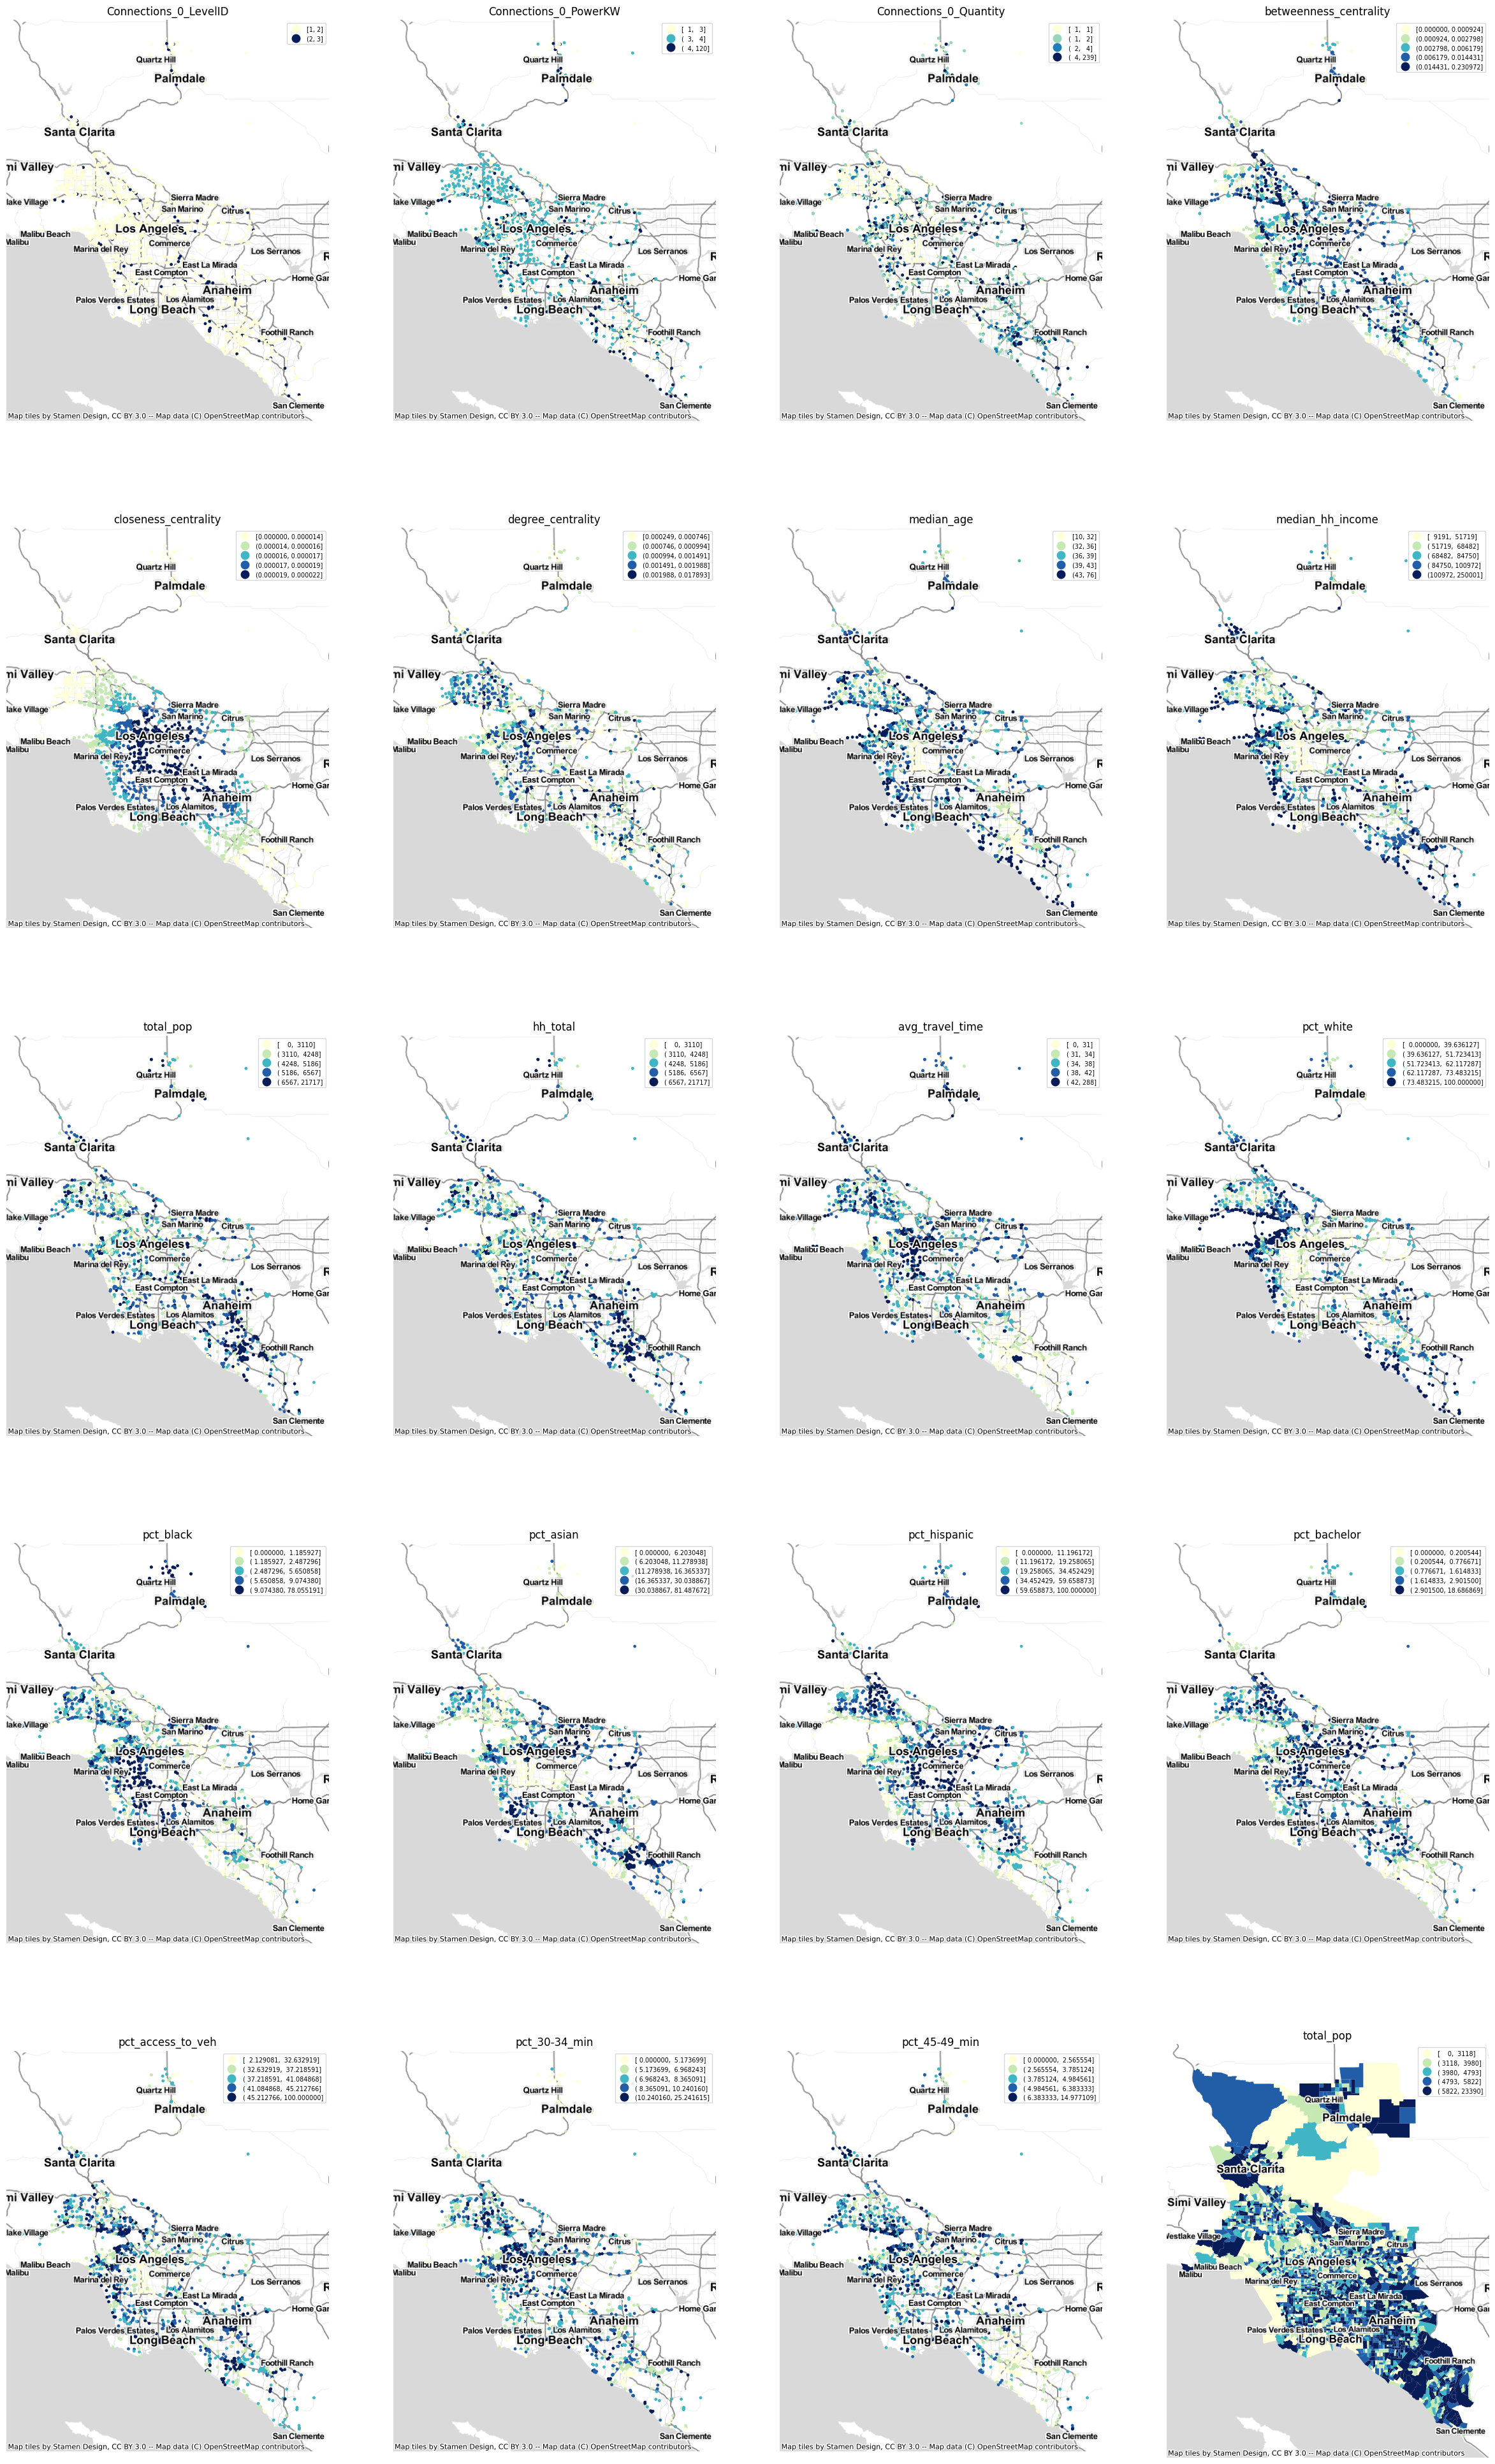

In [1359]:
f, axs = plt.subplots(nrows=5, ncols=4, figsize=(30, 50))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_var):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    if 'pct' in col or 'centrality' in col:
        kwds = {"loc": 1, "fmt": "{:.6f}", "fontsize": "x-small"} #%.2f'
    else:
        kwds = {"loc": 1, "fmt": "{:.0f}", "fontsize": "x-small"}
        
    chargers_socal_acs_kmeans.plot(column=col, 
                                   ax=ax, 
                                   scheme='Quantiles',
                                   k=5,
                                   linewidth=0, 
                                   cmap='YlGnBu', 
                                   legend=True,
                                   markersize=12,
                                   legend_kwds=kwds)
    
    cx.add_basemap(ax, zoom=9, source=cx.providers.Stamen.TonerLite);
    cx.add_basemap(ax, zoom=9, source=cx.providers.Stamen.TonerLabels);
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure

socal_data_kmeans.plot(column='total_pop', 
                       ax=axs[-1],
                       scheme='Quantiles',
                       k=5,
                       linewidth=0, 
                       cmap='YlGnBu', 
                       legend=True,
                       legend_kwds={"loc": 1, "fmt": "{:.0f}", "fontsize": "x-small"})

cx.add_basemap(ax=axs[-1], zoom=9, source=cx.providers.Stamen.TonerLite);
cx.add_basemap(ax=axs[-1], zoom=9, source=cx.providers.Stamen.TonerLabels);
axs[-1].set_axis_off()
axs[-1].set_title('total_pop')


plt.show()
f.savefig('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork/plot/SoCalEVCS_acs_basemap.png', dpi=300)

## Fitting Kmeans

In [1417]:
cluster_var_test = [#'Connections_0_PowerKW', #'Connections_0_LevelID', #, 'Connections_0_Quantity', 
               'betweenness_centrality', 'closeness_centrality', #'degree_centrality',
               'median_age', 'median_hh_income', 'hh_total', #'total_pop',
               'pct_white', 'pct_asian', 'pct_hispanic', #'pct_black',
               'pct_bachelor', 'pct_access_to_veh', 
               'pct_30-34_min', 'pct_45-49_min']#,'avg_travel_time', ]

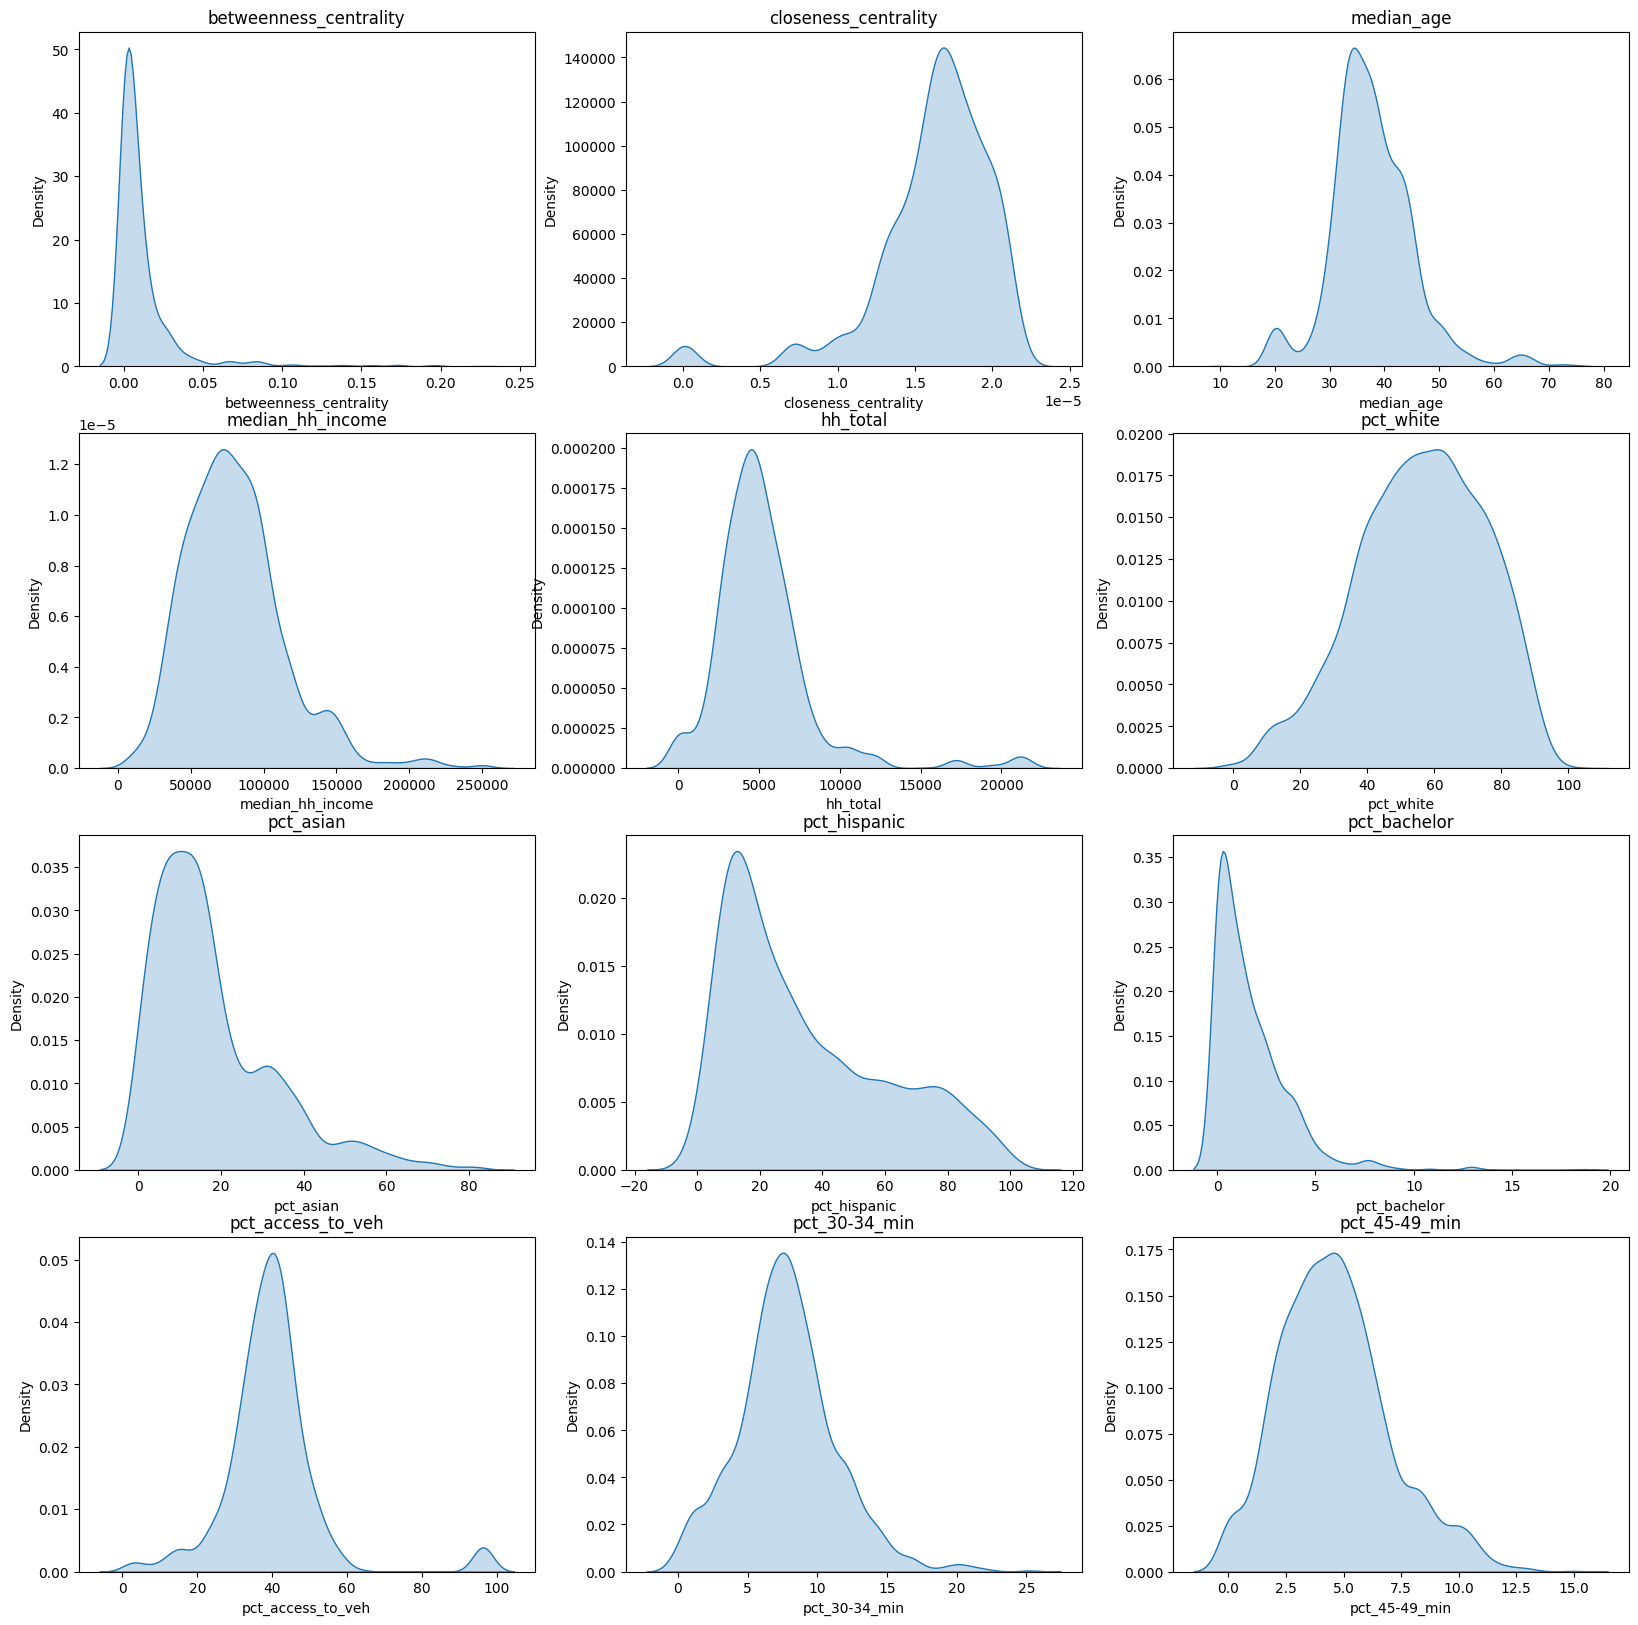

In [1420]:
f, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axs = axs.flatten()

for i, col in enumerate(cluster_var_test):
    ax = axs[i]
    sns.kdeplot(chargers_socal_acs_kmeans[col], fill=True, palette='YlGnBu', ax=ax)
    ax.set_title(col)


plt.show()
f.savefig('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork/plot/SoCalEVCS_acs_kde.png', dpi=300)

In [1421]:
#chargers_socal_acs_kmeans = chargers_socal_acs[cluster_var]

K = range(1, 10)
wss = []

for k in K:
    kmeans=cluster.KMeans(n_clusters=k, init="k-means++", algorithm='full')
    kmeans=kmeans.fit(
        chargers_socal_acs_kmeans[cluster_var_test]
    )
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

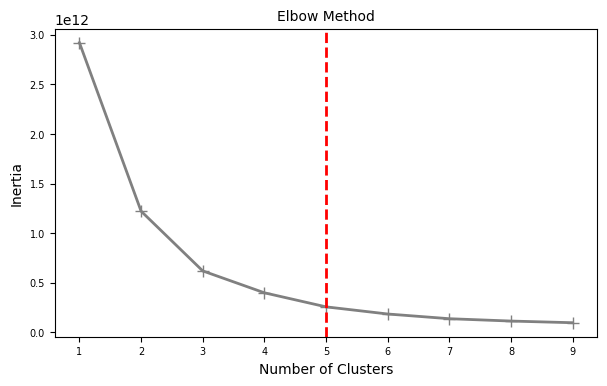

In [1422]:
# Using elbow method to select the correct number of clusters

plt.figure(figsize = (7, 4))
plt.plot(range(1, 10), wss, linewidth = 2, color = 'grey', marker='+', markersize = 8)
plt.title('Elbow Method', fontsize = 10)
plt.xlabel('Number of Clusters',fontsize = 10)
plt.ylabel('Inertia',fontsize = 10)

n_clusters = 5
plt.axvline(x = n_clusters, linewidth = 2, color = 'red', linestyle = '--')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

In [1458]:
# Initialising KMeans instance
kmeans = KMeans(n_clusters=5, algorithm='full')
np.random.seed(1234)
# Running K-Means algorithm
k = kmeans.fit(
    chargers_socal_acs_kmeans[cluster_var_test].replace(
        [np.inf, -np.inf], np.nan
    ).fillna(
        chargers_socal_acs_kmeans.mean())
)

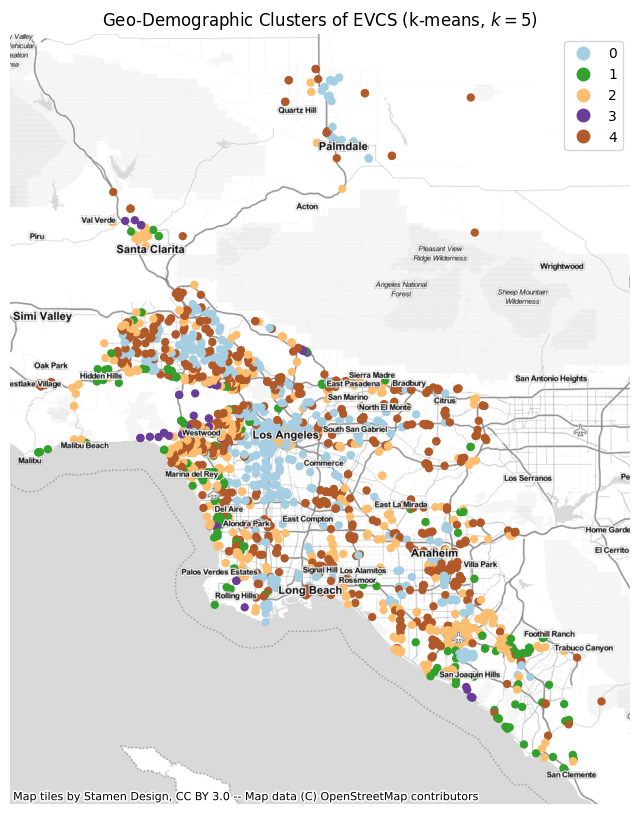

In [1461]:
chargers_socal_acs_kmeans['k'] = k.labels_

f, ax = plt.subplots(1, figsize=(10, 10))
chargers_socal_acs_kmeans.plot(
    column='k', 
    cmap='Paired', 
    categorical=True, 
    legend=True, 
    linewidth=0, 
    ax=ax)

ax.set_axis_off()
cx.add_basemap(ax=ax, zoom=10, source=cx.providers.Stamen.TonerLite);
cx.add_basemap(ax=ax, zoom=10, source=cx.providers.Stamen.TonerLabels);
#plt.axis('equal')
plt.title(r'Geo-Demographic Clusters of EVCS (k-means, $k=5$)')
plt.show()
f.savefig('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork/plot/SoCalEVCS_acs_clustered.png', dpi=300)

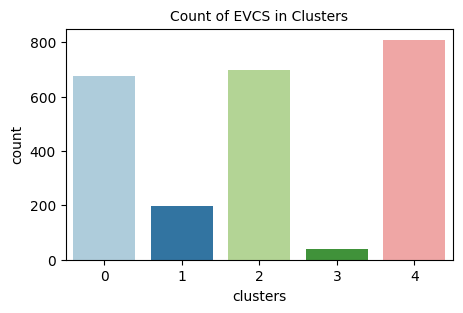

In [1524]:
# Grouping data table by cluster label and count observations
f, ax = plt.subplots(1, figsize=(5, 3))
ksizes = chargers_socal_acs_kmeans.groupby('k').size().to_frame(name='count').reset_index()
sns.barplot('k', data=ksizes, y='count', palette='Paired', ax=ax);

plt.title('Count of EVCS in Clusters', fontsize = 10);
plt.xlabel('clusters', fontsize = 10)
plt.ylabel('count', fontsize = 10)
f.savefig('plot/SoCalEVCS_acs_cluster_count.png', dpi=300)

In [1525]:
# Grouping table by cluster label
kmeans = chargers_socal_acs_kmeans.groupby('k')[cluster_var_test].mean()
kmeans.T.round(3)

k                               0           1          2           3  \
betweenness_centrality      0.018       0.006      0.009       0.006   
closeness_centrality        0.000       0.000      0.000       0.000   
median_age                 34.494      43.100     39.551      46.761   
median_hh_income        43559.350  141611.313  99977.397  209421.512   
hh_total                 4761.037    5688.399   6073.885    4366.561   
pct_white                  45.098      70.082     61.425      77.450   
pct_asian                  15.337      18.582     20.947      14.581   
pct_hispanic               52.122      12.690     20.153       8.379   
pct_bachelor                2.904       0.484      0.867       0.166   
pct_access_to_veh          31.559      40.002     41.651      33.666   
pct_30-34_min               8.473       7.128      7.144       5.981   
pct_45-49_min               4.025       4.499      4.803       4.473   

k                               4  
betweenness_centrality      0.011  
closeness_centrality        0.000  
median_age                 37.087  
median_hh_income        72294.542  
hh_total                 4695.306  
pct_white                  56.002  
pct_asian                  17.287  
pct_hispanic               38.619  
pct_bachelor                1.765  
pct_access_to_veh          44.798  
pct_30-34_min               8.073  
pct_45-49_min               4.978

In [1465]:
# Index db on cluster ID

tidy_db = chargers_socal_acs_kmeans.set_index('k')
tidy_db = tidy_db[cluster_var_test].stack().reset_index()
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})

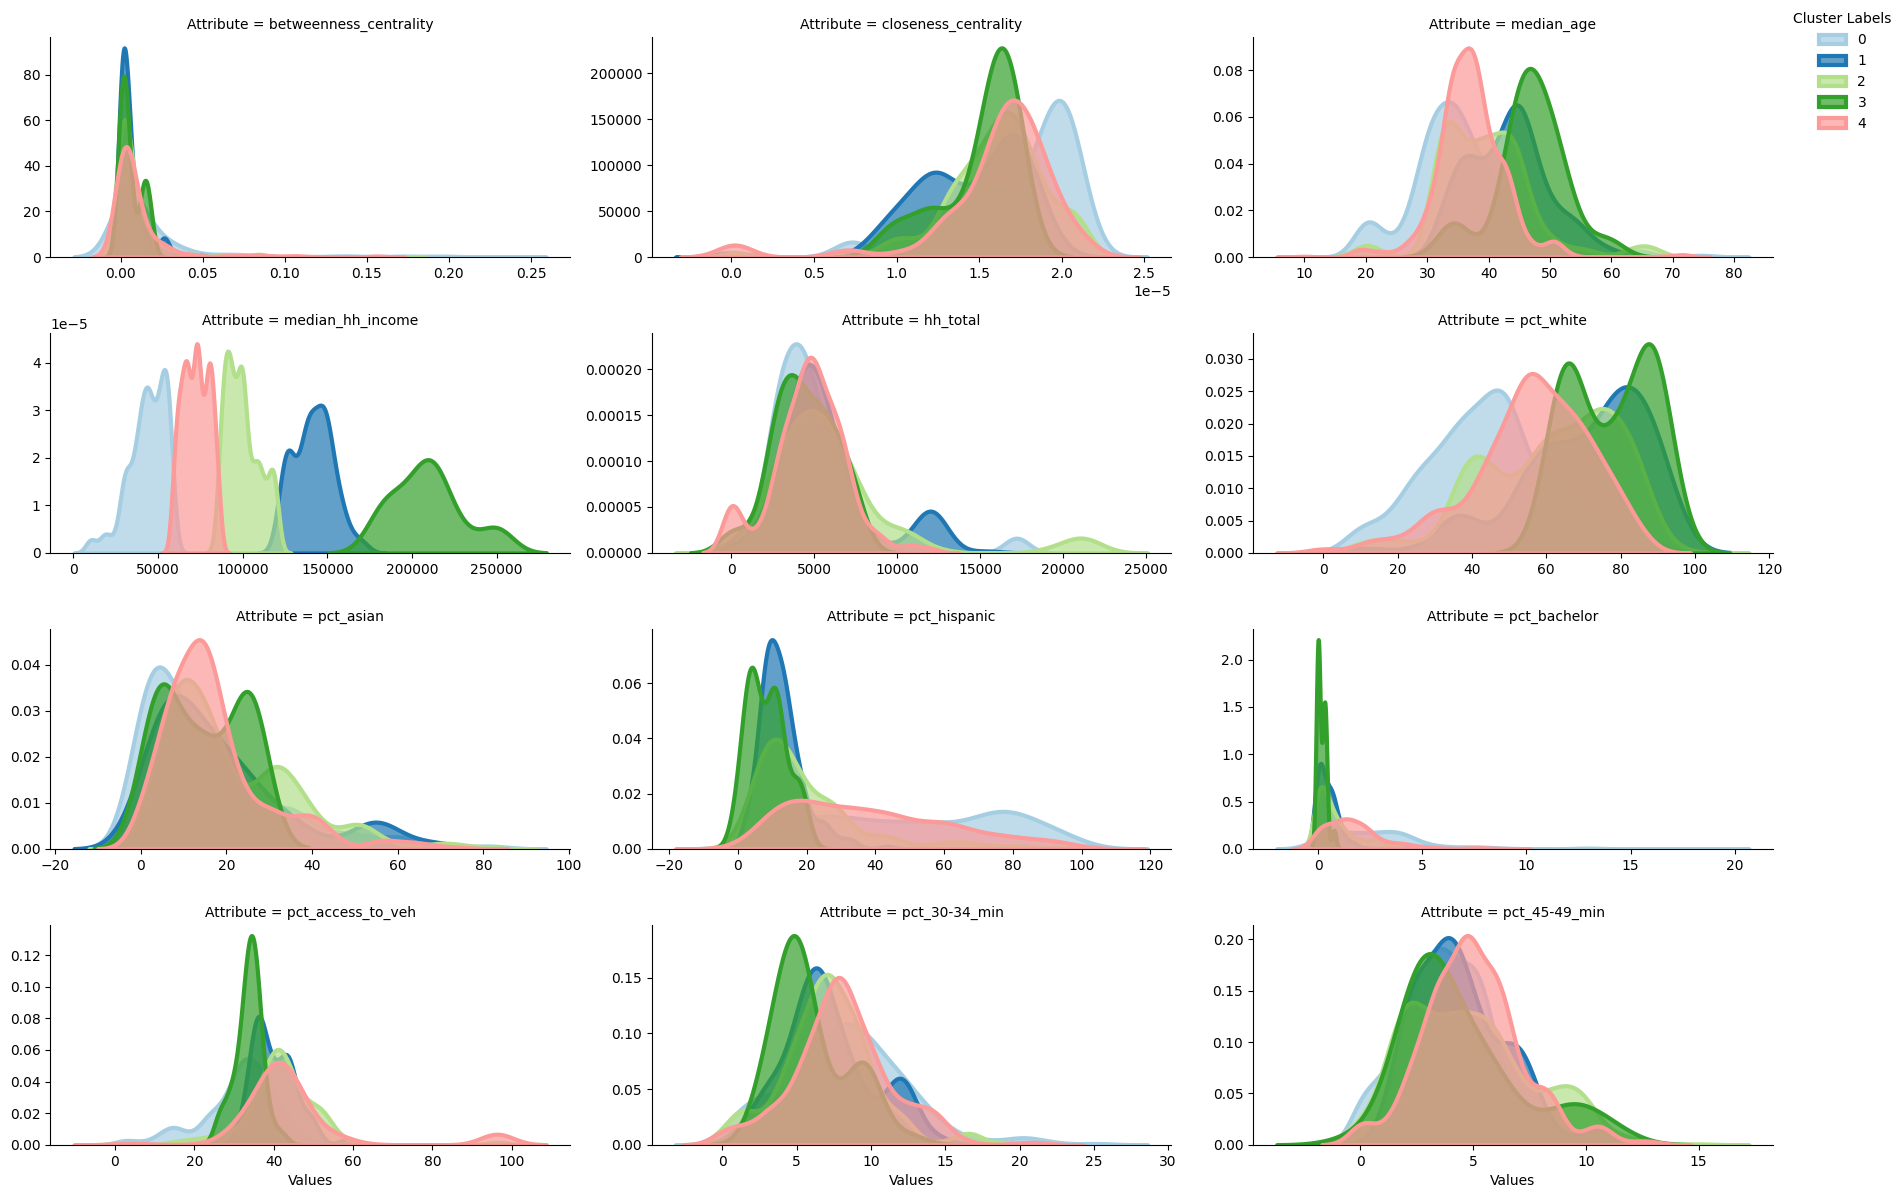

In [1467]:
# Setup the facets

facets = sns.FacetGrid(
    data=tidy_db, col='Attribute', 
    palette='Paired', hue='k',
    sharey=False, sharex=False,
    aspect=2, col_wrap=3, 
    legend_out=True)

mx = facets.map(
    sns.kdeplot, 
    'Values', 
    shade=True, legend=True, alpha=.7, linewidth=3).add_legend(
    title='Cluster Labels', loc=1
)


plt.show()
mx.savefig('plot/SoCalEVCS_acs_cluster_dist.png', dpi=300)